In [1]:
#Problem: With the insurgence of indie games on Steam, it is hard to determine what would make a successful indie game. 
#Questions: What genres of indie games are most popular? Which ones are oversaturated? If I wanted to make a successful indie game, what genre should I make it in?
#Data Sources: SteamSpy, Storefront API, Steam Web API
#Steam Web API (key: DCD8AAAB9BA14A860C20C9138E54CB50, domain name: blackmoose)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.feature_selection import SelectFromModel, RFE
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer


In [3]:
#importing data from csv files
steamspy_df = pd.read_csv('steamspy_all_games.csv')
storefront_df_raw = pd.read_csv('storefront_data.csv')

In [4]:
print(storefront_df_raw.head(2))
print(storefront_df_raw['genres'].head(2).tolist())
#this is showing that the json is stringified, so we need to convert it to a real list before we can use it
storefront_df_raw['genres_parsed'] = storefront_df_raw['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
storefront_df_raw['genres_parsed'].head(2).tolist()

     appid                                             genres  type  \
0      730  [{'id': '1', 'description': 'Action'}, {'id': ...  game   
1  1172470  [{'id': '1', 'description': 'Action'}, {'id': ...  game   

                                     release_date  
0  {'coming_soon': False, 'date': '21 Aug, 2012'}  
1   {'coming_soon': False, 'date': 'Nov 4, 2020'}  
["[{'id': '1', 'description': 'Action'}, {'id': '37', 'description': 'Free To Play'}]", "[{'id': '1', 'description': 'Action'}, {'id': '25', 'description': 'Adventure'}, {'id': '37', 'description': 'Free To Play'}]"]


[[{'id': '1', 'description': 'Action'},
  {'id': '37', 'description': 'Free To Play'}],
 [{'id': '1', 'description': 'Action'},
  {'id': '25', 'description': 'Adventure'},
  {'id': '37', 'description': 'Free To Play'}]]

In [5]:
storefront_df = storefront_df_raw.drop(columns=['genres', 'release_date', 'genres_parsed'])
print(storefront_df_raw['genres'].head())
storefront_df['genres_list'] = storefront_df_raw['genres_parsed'].apply(lambda x: [g['description'] for g in x if 'description' in g] if isinstance(x, list) else [])
print(storefront_df.columns)
print(storefront_df.head())
print(len(storefront_df))

0    [{'id': '1', 'description': 'Action'}, {'id': ...
1    [{'id': '1', 'description': 'Action'}, {'id': ...
2    [{'id': '1', 'description': 'Action'}, {'id': ...
3    [{'id': '1', 'description': 'Action'}, {'id': ...
4    [{'id': '1', 'description': 'Action'}, {'id': ...
Name: genres, dtype: object
Index(['appid', 'type', 'genres_list'], dtype='object')
     appid  type                                        genres_list
0      730  game                             [Action, Free To Play]
1  1172470  game                  [Action, Adventure, Free To Play]
2   578080  game  [Action, Adventure, Massively Multiplayer, Fre...
3  1623730  game      [Action, Adventure, Indie, RPG, Early Access]
4      440  game                             [Action, Free To Play]
86390


In [6]:
print(steamspy_df.describe())
print(steamspy_df.columns)
print(steamspy_df.head())
print(len(steamspy_df))

              appid  score_rank      positive      negative     userscore  \
count  8.652800e+04   43.000000  8.652800e+04  8.652800e+04  86528.000000   
mean   1.530538e+06   99.232558  1.470238e+03  2.419816e+02      0.038508   
std    9.059966e+05    0.648706  3.264946e+04  6.194527e+03      1.766213   
min    1.000000e+01   98.000000  0.000000e+00  0.000000e+00      0.000000   
25%    7.795775e+05   99.000000  5.000000e+00  1.000000e+00      0.000000   
50%    1.382915e+06   99.000000  1.800000e+01  5.000000e+00      0.000000   
75%    2.212212e+06  100.000000  9.500000e+01  2.700000e+01      0.000000   
max    3.744990e+06  100.000000  7.642084e+06  1.173003e+06    100.000000   

       average_forever  average_2weeks  median_forever  median_2weeks  \
count     86528.000000    86528.000000    86528.000000   86528.000000   
mean        223.022605       14.795373      191.611166      15.662479   
std        4223.636880      213.135683     5336.906312     241.607244   
min           

In [7]:
#Because not all rows were successfully extracted from API, there is a mismatch in the number of rows between the two dataframes. For this reason, we will use merge on dataframes to combine them.
df = pd.merge(storefront_df, steamspy_df, left_on='appid', right_on='appid', how='inner')
print(df.head())
print(len(df))
#RED FLAG: 
#there are 93787 which is larger than the two individual dataframes, so it is likely that some rows were duplicated in the merge, or there are some mismatched appids in the two dataframes.
#Should not be more than the individual dataframes, due to the inner join.

     appid  type                                        genres_list  \
0      730  game                             [Action, Free To Play]   
1  1172470  game                  [Action, Adventure, Free To Play]   
2   578080  game  [Action, Adventure, Massively Multiplayer, Fre...   
3  1623730  game      [Action, Adventure, Indie, RPG, Early Access]   
4      440  game                             [Action, Free To Play]   

                               name         developer        publisher  \
0  Counter-Strike: Global Offensive             Valve            Valve   
1                      Apex Legends           Respawn  Electronic Arts   
2               PUBG: BATTLEGROUNDS  PUBG Corporation    KRAFTON, Inc.   
3                          Palworld        Pocketpair       Pocketpair   
4                   Team Fortress 2             Valve            Valve   

   score_rank  positive  negative  userscore                      owners  \
0         NaN   7642084   1173003          0  100,00

In [8]:
#Looking why there is more in the merged dataframe than in the individual dataframes
#checking for duplicates in the individual dataframes
print("Storefront duplicates previous to remove:", storefront_df['appid'].duplicated().sum(), "Length pre-duplicates:", len(storefront_df))
print("Steamspy duplicates previous to remove:", steamspy_df['appid'].duplicated().sum(), "Length pre-duplicates:", len(steamspy_df))
storefront_df = storefront_df.drop_duplicates(subset='appid')
steamspy_df = steamspy_df.drop_duplicates(subset='appid')
print("Storefront duplicates after drop:", storefront_df['appid'].duplicated().sum(), "Length post-duplicates:", len(storefront_df))
print("Steamspy duplicates after drop:", steamspy_df['appid'].duplicated().sum(), "Length post-duplicates:", len(steamspy_df))

df = pd.merge(storefront_df, steamspy_df, left_on='appid', right_on='appid', how='inner')
print("Merged duplicates after drop:", df['appid'].duplicated().sum(), "Length post-duplicates:", len(df))
if len(df) > len(storefront_df) and len(df) > len(steamspy_df):
    print("There are still more rows in the merged dataframe than in the individual dataframes. There may be some mismatched appids in the two dataframes.")
else:
    print("The merged dataframe has the same number or fewer rows as the individual dataframes. There are no mismatched appids.")

Storefront duplicates previous to remove: 3760 Length pre-duplicates: 86390
Steamspy duplicates previous to remove: 3773 Length pre-duplicates: 86528
Storefront duplicates after drop: 0 Length post-duplicates: 82630
Steamspy duplicates after drop: 0 Length post-duplicates: 82755
Merged duplicates after drop: 0 Length post-duplicates: 82547
The merged dataframe has the same number or fewer rows as the individual dataframes. There are no mismatched appids.


In [9]:
#Looking for NAs in the merged dataframe
print("NAs in merged dataframe:", df.isna().sum())
print("percent of NAs in merged dataframe:", df.isna().sum() / len(df) * 100)

#Missing Data handling
#score_rank has a lot of NAs, so we will drop the column
#Name, Developer, and Publisher have some NAs, so we will drop those rows since we cannot impute them meaningfully
df = df.drop(columns=['score_rank'])
df = df.dropna()
print("NAs in merged dataframe after drop:", df.isna().sum())
print("Length of merged dataframe after drop:", len(df))

NAs in merged dataframe: appid                  0
type                   0
genres_list            0
name                  11
developer            209
publisher            483
score_rank         82510
positive               0
negative               0
userscore              0
owners                 0
average_forever        0
average_2weeks         0
median_forever         0
median_2weeks          0
price                  0
initialprice           0
discount               0
ccu                    0
dtype: int64
percent of NAs in merged dataframe: appid               0.000000
type                0.000000
genres_list         0.000000
name                0.013326
developer           0.253189
publisher           0.585121
score_rank         99.955177
positive            0.000000
negative            0.000000
userscore           0.000000
owners              0.000000
average_forever     0.000000
average_2weeks      0.000000
median_forever      0.000000
median_2weeks       0.000000
price           

In [10]:
#looking at what columns we need to clean next
print(df.dtypes)
print(df.head(5))
#Owners is a string, with a range of values (e.g. "100,000 to 200,000"). How necessary is this column? If we keep it, we will need to convert it to a numerical value. But there is no way
#to parse the information in a meaningful way, since there will be a many repeated values for different games. Will this add noise or meaninful information to the dataset?
#Genres_list needs to be encoded to a numerical value, since it is a list of strings. We can use  encoding to do this.
#Additionally, the "indie" column from the  encoding + the type will be used to filter the dataframe to only include indie games.
#CCU variable also poses a problem with analysis, so we will approach it with caution. CCU = Concurrent Users, which is a snapshot of the number of users playing the game at the time of import. 
#This can be useful or can add unnecessary noise because it is heavily affected by multiple factors, such as time of day, day of the week, season, whether it is on sale, popularity by region, etc.
#We will keep it for now, and see how much information it adds to the models.

#NEXT STEPS:
#1. Before looking further at the data, we need to  encode the genres_list column to create a new dataframe with the genres as columns.
#2. We will then filter the dataframe to only include indie games, and create a new dataframe with only the indie games.
#3. Futher EDA on the subset of indie games to look at distributions of other columns. 
#4. Re-assess what next steps are needed after EDA.


appid                int64
type                object
genres_list         object
name                object
developer           object
publisher           object
positive             int64
negative             int64
userscore            int64
owners              object
average_forever      int64
average_2weeks       int64
median_forever       int64
median_2weeks        int64
price              float64
initialprice       float64
discount           float64
ccu                  int64
dtype: object
     appid  type                                        genres_list  \
0      730  game                             [Action, Free To Play]   
1  1172470  game                  [Action, Adventure, Free To Play]   
2   578080  game  [Action, Adventure, Massively Multiplayer, Fre...   
3  1623730  game      [Action, Adventure, Indie, RPG, Early Access]   
4      440  game                             [Action, Free To Play]   

                               name         developer        publisher  \

In [11]:
#separating out the genres_list column to view what breakdown is
genres_df = df['genres_list'].str.join('|').str.get_dummies()
print(genres_df.columns)
print(len(genres_df.columns))

#Unexpected issue of multiple languages for the genres, so two ways to approach this:
#1. Easier method: Use the ID of the genres from the Steam API, which might be consistent across languages.
#1a. This would require us to look up the IDs for each genre, and then create a mapping from the genre name to the ID.
#2. More complex method: Use the genres as they are, but this will require us to clean the data further to ensure that the genres are consistent across languages.
#2a. This would require us to create a mapping from the genre name to a standard name, and then  encode the standard names.

#we will obviously start with the easier method.

Index(['Abenteuer', 'Acceso anticipado', 'Acción', 'Accounting',
       'Acesso Antecipado', 'Action', 'Adventure', 'Akció', 'Akcja',
       'Animation & Modeling', 'Audio Production', 'Aventura', 'Avventura',
       'Ação', 'Casual', 'Corridas', 'Corse', 'Design & Illustration',
       'Early Access', 'Education', 'Estratégia', 'Free To Play', 'GDR',
       'Game Development', 'Gelegenheitsspiele', 'Gore', 'Indie',
       'Indépendant', 'Massively Multiplayer', 'Movie',
       'Multigiocatore di massa', 'Multijugador masivo', 'Niezależne',
       'Nudity', 'Passatempo', 'Photo Editing', 'Przygodowe', 'RPG', 'Racing',
       'Rekreacyjne', 'Rennspiele', 'Rol', 'Rollenspiel', 'Sexual Content',
       'Short', 'Simulation', 'Simulationen', 'Simulazione', 'Simulação',
       'Software Training', 'Sport', 'Sports', 'Strategy', 'Stratégia',
       'Symulacje', 'Szimuláció', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing', 'Αγώνες ταχύτητας', 'Δράση', 'Προσομοίωση', 'Инди

In [12]:
#Now instead of parsing genres from the descriptions, we will parse the genres from the id.
#If there is the same number of columns created as the number of columns above, then we will need to try the other method (since ids would not be consistent across languages).
#copy our line from above and change 'description' to 'id'

storefront_df['genres_list_id'] = storefront_df_raw['genres_parsed'].apply(lambda x: [g['id'] for g in x if 'id' in g] if isinstance(x, list) else [])
genres_df_id = storefront_df['genres_list_id'].str.join('|').str.get_dummies()
print(genres_df_id.columns)
print(len(genres_df_id.columns))

#This looks consistent across languages, sicne there are 60 less columns created
#Next step is duplicate this method into the main dataframe
#Create a mapping dictionary to then add description in EN to each id.


Index(['1', '18', '2', '23', '25', '28', '29', '3', '37', '4', '50', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '60', '70', '71', '72',
       '73', '74', '80', '83', '9'],
      dtype='object')
29


In [13]:
#merging again and dropping pertinent columns to replace the genre_list with the genre_list_id in the merged df
df = pd.merge(storefront_df, steamspy_df, left_on='appid', right_on='appid', how='inner')
print("Merged duplicates after drop:", df['appid'].duplicated().sum(), "Length post-duplicates:", len(df))
if len(df) > len(storefront_df) and len(df) > len(steamspy_df):
    print("There are still more rows in the merged dataframe than in the individual dataframes. There may be some mismatched appids in the two dataframes.")
else:
    print("The merged dataframe has the same number or fewer rows as the individual dataframes. There are no mismatched appids.")
df = df.drop(columns='genres_list')
print(df.columns)
print(len(df))
#double checking that the rows match to the merge before to ensure no issues with this process
if len(df) == 82547:
    print("No Flags")
else:
    print("ERROR")

Merged duplicates after drop: 0 Length post-duplicates: 82547
The merged dataframe has the same number or fewer rows as the individual dataframes. There are no mismatched appids.
Index(['appid', 'type', 'genres_list_id', 'name', 'developer', 'publisher',
       'score_rank', 'positive', 'negative', 'userscore', 'owners',
       'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks',
       'price', 'initialprice', 'discount', 'ccu'],
      dtype='object')
82547
No Flags


In [14]:
#Creating a dictionary to map the ids to the EN descriptions so results are interpretable
#ASSUMPTION: English descriptions will be in the front. This method takes the first description for each id to map them together, if there is an error will have to manually change.
all_genres = storefront_df_raw['genres_parsed'].dropna().explode()
genre_dicts = [g for g in all_genres if isinstance(g, dict) and 'id' in g and 'description' in g]
genre_map = {}
for g in genre_dicts:
    genre_map[g['id']] = genre_map.get(g['id'], g['description'])
print(genre_map.values())
if len(genre_map.keys()) == len(genres_df_id.columns):
    print("No Flags")
else:
    print("ERROR")
#Looks like that maps correctly to the number of ids that were made in the  encoding above. Visual check shows that all the of the descriptions were in english

dict_values(['Action', 'Free To Play', 'Adventure', 'Massively Multiplayer', 'Indie', 'RPG', 'Early Access', 'Casual', 'Simulation', 'Animation & Modeling', 'Design & Illustration', 'Photo Editing', 'Utilities', 'Strategy', 'Sports', 'Racing', 'Video Production', 'Education', 'Game Development', 'Audio Production', 'Violent', 'Software Training', 'Web Publishing', 'Nudity', 'Gore', 'Movie', 'Sexual Content', 'Accounting', 'Short'])
No Flags


In [15]:
#Mapping the english description to the genres_list_id column, so that we create a column with english descriptions for  encoding.
df['genres_list'] = df['genres_list_id'].apply(
    lambda id_list: [genre_map.get(i, f"Unknown-{i}") for i in id_list]
)

#Double checking to ensure accuracy
#encoding the genres_list column
genres_df = df['genres_list'].str.join('|').str.get_dummies()
print(genres_df.columns)
print(len(genres_df.columns))
print(genres_df.head(5))
print(df['genres_list'].head())
#printed both to triple check that mapping was done correctly. Visual check shows correctness

Index(['Accounting', 'Action', 'Adventure', 'Animation & Modeling',
       'Audio Production', 'Casual', 'Design & Illustration', 'Early Access',
       'Education', 'Free To Play', 'Game Development', 'Gore', 'Indie',
       'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG',
       'Racing', 'Sexual Content', 'Short', 'Simulation', 'Software Training',
       'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent',
       'Web Publishing'],
      dtype='object')
29
   Accounting  Action  Adventure  Animation & Modeling  Audio Production  \
0           0       1          0                     0                 0   
1           0       1          1                     0                 0   
2           0       1          1                     0                 0   
3           0       1          1                     0                 0   
4           0       1          0                     0                 0   

   Casual  Design & Illustration  Early Access

In [16]:
#Cleaning up again before encoding
print(df.columns)
df = df.drop(columns=['genres_list_id', 'score_rank'])
df = df.dropna()
print(df.isna().sum())

Index(['appid', 'type', 'genres_list_id', 'name', 'developer', 'publisher',
       'score_rank', 'positive', 'negative', 'userscore', 'owners',
       'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks',
       'price', 'initialprice', 'discount', 'ccu', 'genres_list'],
      dtype='object')
appid              0
type               0
name               0
developer          0
publisher          0
positive           0
negative           0
userscore          0
owners             0
average_forever    0
average_2weeks     0
median_forever     0
median_2weeks      0
price              0
initialprice       0
discount           0
ccu                0
genres_list        0
dtype: int64


In [17]:
print(df['genres_list'])

0                                   [Action, Free To Play]
1                        [Action, Adventure, Free To Play]
2        [Action, Adventure, Massively Multiplayer, Fre...
3            [Action, Adventure, Indie, RPG, Early Access]
4                                   [Action, Free To Play]
                               ...                        
82542                                   [Adventure, Indie]
82543                                          [Adventure]
82544                                 [Casual, Simulation]
82545                                      [Casual, Indie]
82546                                      [Casual, Indie]
Name: genres_list, Length: 81924, dtype: object


In [18]:
#encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres_list'])

genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)
df_encoded = pd.concat([df, genres_df], axis=1)
print(df_encoded.columns)

Index(['appid', 'type', 'name', 'developer', 'publisher', 'positive',
       'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks',
       'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount',
       'ccu', 'genres_list', 'Accounting', 'Action', 'Adventure',
       'Animation & Modeling', 'Audio Production', 'Casual',
       'Design & Illustration', 'Early Access', 'Education', 'Free To Play',
       'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short',
       'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Web Publishing'],
      dtype='object')


In [19]:
#filtering to just Indie games to do some further EDA
df_indie = df_encoded[(df_encoded['Indie'] == 1) & (df_encoded['type'] == 'game')]

In [20]:
print(len(df_indie))
print(df_indie.columns)
print(df_indie.dtypes)
df_indie.describe()

58158
Index(['appid', 'type', 'name', 'developer', 'publisher', 'positive',
       'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks',
       'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount',
       'ccu', 'genres_list', 'Accounting', 'Action', 'Adventure',
       'Animation & Modeling', 'Audio Production', 'Casual',
       'Design & Illustration', 'Early Access', 'Education', 'Free To Play',
       'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short',
       'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Web Publishing'],
      dtype='object')
appid                      int64
type                      object
name                      object
developer                 object
publisher                 object
positive                   int64
negative                   int64
userscore          

,appid,positive,negative,userscore,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,...,Sexual Content,Short,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Violent,Web Publishing
count,5.815800e+04,5.815800e+04,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,...,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000,58158.000000
mean,1.550077e+06,8.855417e+02,109.019791,0.032635,161.531122,9.984078,145.613828,10.704546,600.132364,719.501100,...,0.001221,0.000017,0.206455,0.000344,0.041009,0.203291,0.001169,0.000430,0.005519,0.000189
std,8.939777e+05,1.454399e+04,1423.851297,1.615583,4548.043888,180.932813,5175.343720,203.362391,1104.739964,1196.449446,...,0.034919,0.004147,0.404764,0.018541,0.198313,0.402451,0.034174,0.020729,0.074088,0.013752
min,1.002000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.110475e+05,5.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,199.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.381875e+06,1.700000e+01,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,399.000000,499.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.220840e+06,8.000000e+01,22.000000,0.000000,19.000000,0.000000,18.000000,0.000000,799.000000,999.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.744990e+06,1.373979e+06,156649.000000,100.000000,944160.000000,20059.000000,944160.000000,20059.000000,99998.000000,99998.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#df_indie[['price', 'initialprice', 'discount']].describe()
#print(df_indie['price'].max())
#There is an issue with price since there are games listed for 99,998. Based on search issue arises because there are other currency besides USD. 
#Identifying non USD prices and converting to USD will take too much time.
#Going to remove Price features above in the drop fucntion.


In [22]:
#cleaning owners column, so that it is represented numerically. Keeping the lower bound and not both bounds. 
#Due to it being a repeated range for features, both bounds does not provide any additional information
print(df_indie['owners'].head())
df_indie['owners_lower'] = df_indie['owners'].str.split(" ..").str[0].str.replace(',','').astype(int)
print(df_indie['owners_lower'].head())

3     50,000,000 .. 100,000,000
10    50,000,000 .. 100,000,000
17     20,000,000 .. 50,000,000
19     20,000,000 .. 50,000,000
21     20,000,000 .. 50,000,000
Name: owners, dtype: object
3     50000000
10    50000000
17    20000000
19    20000000
21    20000000
Name: owners_lower, dtype: int32


C:\Users\Liam\AppData\Local\Temp\ipykernel_27368\6777931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indie['owners_lower'] = df_indie['owners'].str.split(" ..").str[0].str.replace(',','').astype(int)


In [23]:
#Final feature to code is same publisher and developer (coding all string variables from database and dropping them)
df_indie["same_dev_pub"] = (
    df_indie['developer'].str.strip() ==
    df_indie['publisher'].str.strip()
).astype(int)
df_indie['same_dev_pub'].describe()

C:\Users\Liam\AppData\Local\Temp\ipykernel_27368\2159890701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indie["same_dev_pub"] = (


count    58158.000000
mean         0.735651
std          0.440990
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: same_dev_pub, dtype: float64

In [24]:
#dropping string variables and appid. If wanting to see this information, df_indie and df_final have matching rows (both size and order), so can look this information up in df_indie
df_final = df_indie.drop(columns=['genres_list', 'price', 'initialprice', 'discount', 'owners','publisher', 'developer', 'type','name', 'appid', 'Indie'])
print(df_final.dtypes)

positive                 int64
negative                 int64
userscore                int64
average_forever          int64
average_2weeks           int64
median_forever           int64
median_2weeks            int64
ccu                      int64
Accounting               int32
Action                   int32
Adventure                int32
Animation & Modeling     int32
Audio Production         int32
Casual                   int32
Design & Illustration    int32
Early Access             int32
Education                int32
Free To Play             int32
Game Development         int32
Gore                     int32
Massively Multiplayer    int32
Movie                    int32
Nudity                   int32
Photo Editing            int32
RPG                      int32
Racing                   int32
Sexual Content           int32
Short                    int32
Simulation               int32
Software Training        int32
Sports                   int32
Strategy                 int32
Utilitie

In [25]:
genre_list = ['Accounting', 'Action', 'Adventure',
       'Animation & Modeling', 'Audio Production', 'Casual',
       'Design & Illustration', 'Early Access', 'Education', 'Free To Play',
       'Game Development', 'Gore', 'Massively Multiplayer', 'Movie',
       'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Short',
       'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities',
       'Video Production', 'Violent', 'Web Publishing']
target_variables = ['positive', 'negative', 'userscore', 'owners_lower', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'ccu']
#Potential Target Variables:
#'positive', 'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'ccu'
#initially something like owners_lower would stand out as a good target variables because it shows how many people total have bought the game
#This works under the assumption that profit comes solely from game purchase, but neglects in game purchases or other prolonged purchases
#For games that profit from extent of playtime (in-game purchases, dlcs, etc.):
#something like median_forever or median_2week or ccu would be a better indicator of profit therefore a better target variable

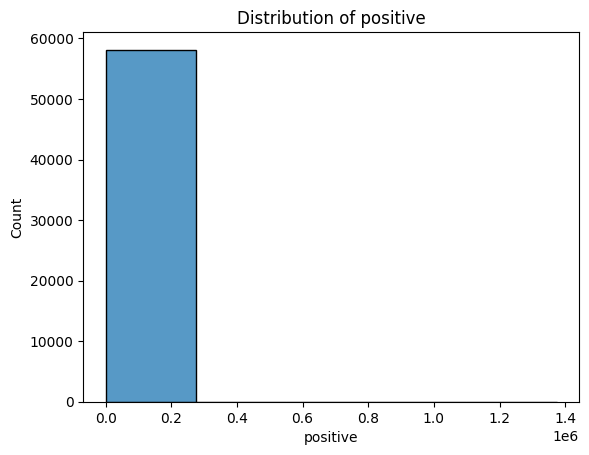

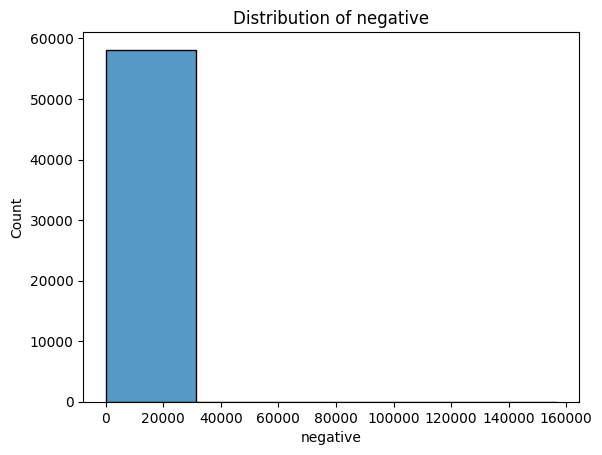

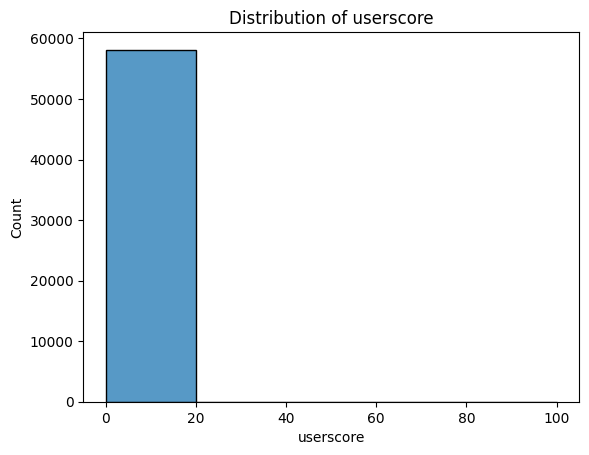

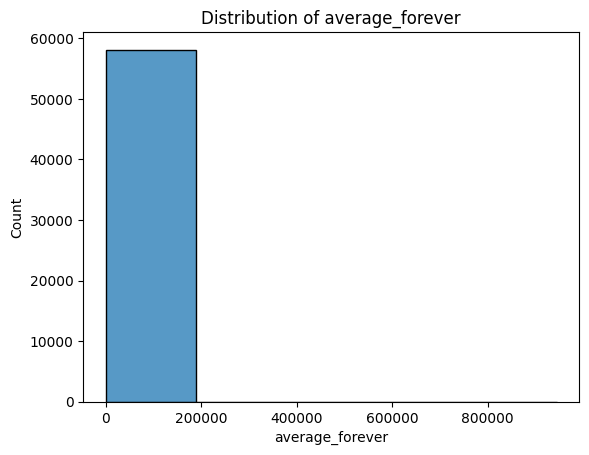

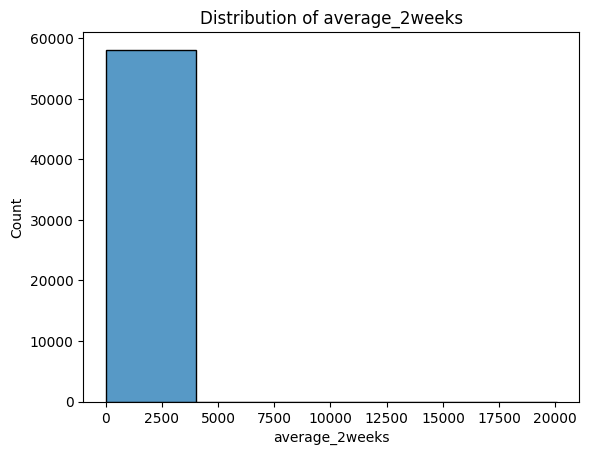

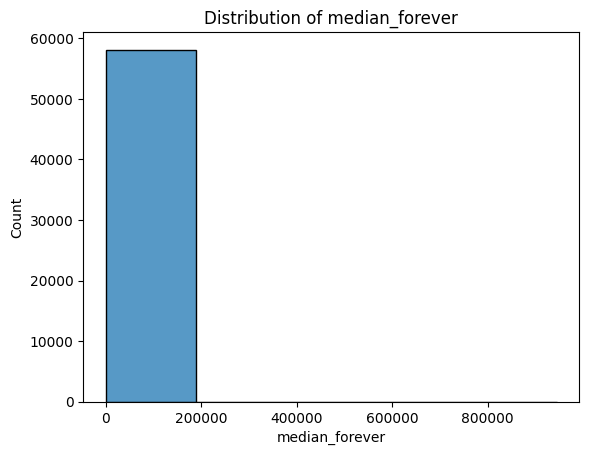

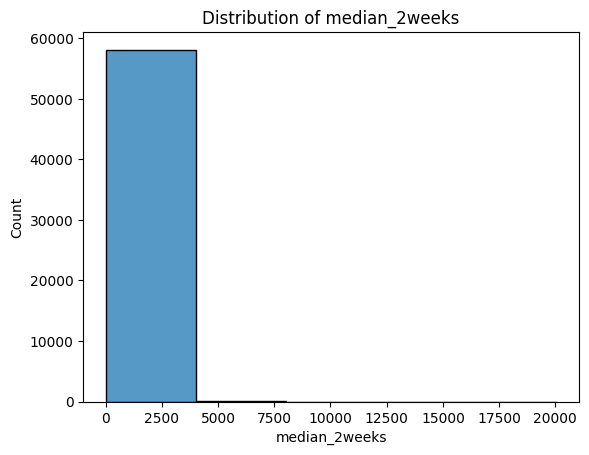

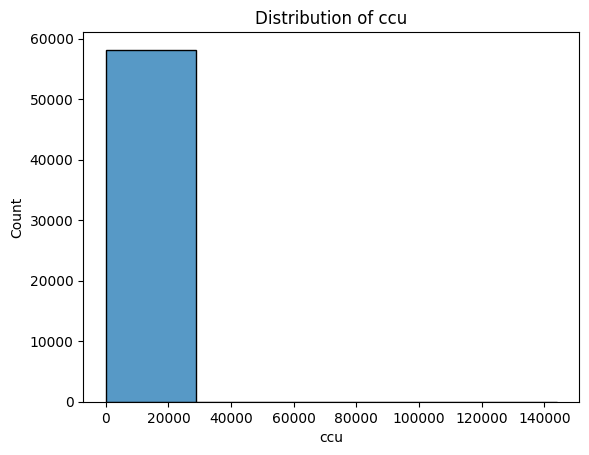

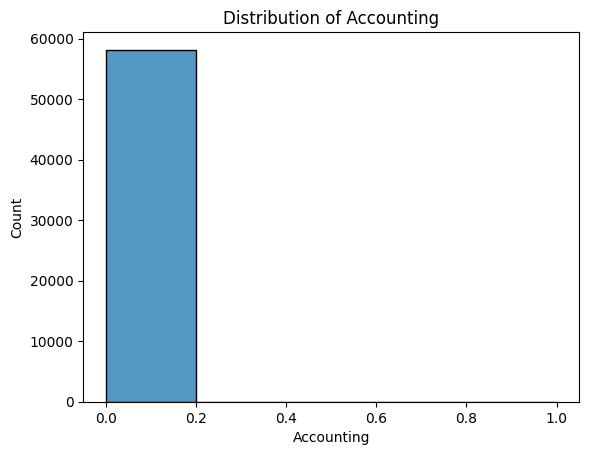

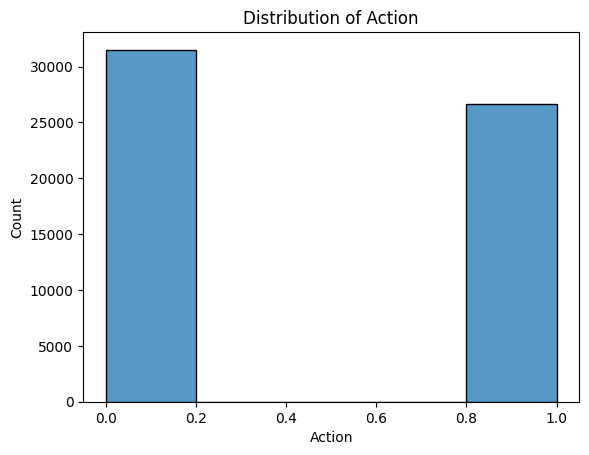

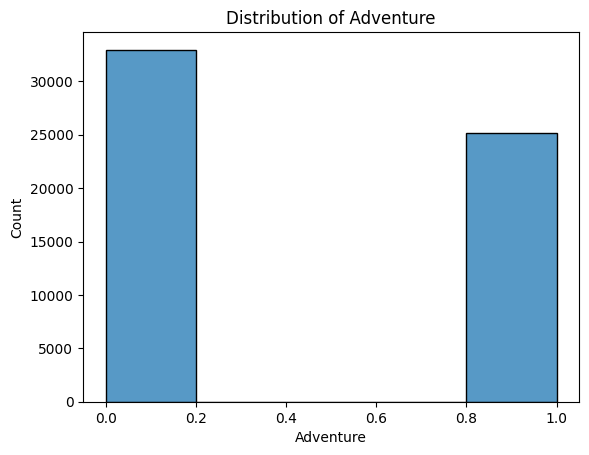

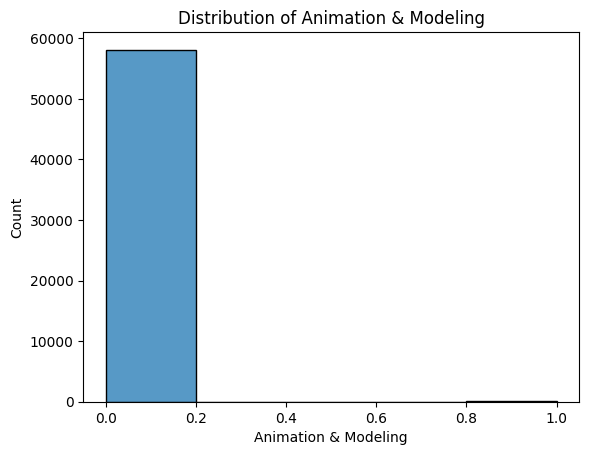

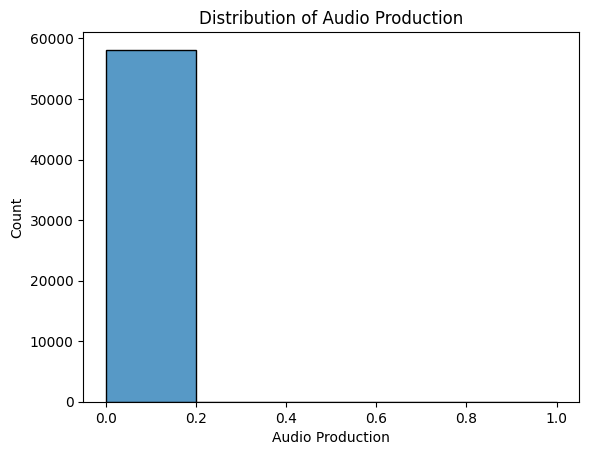

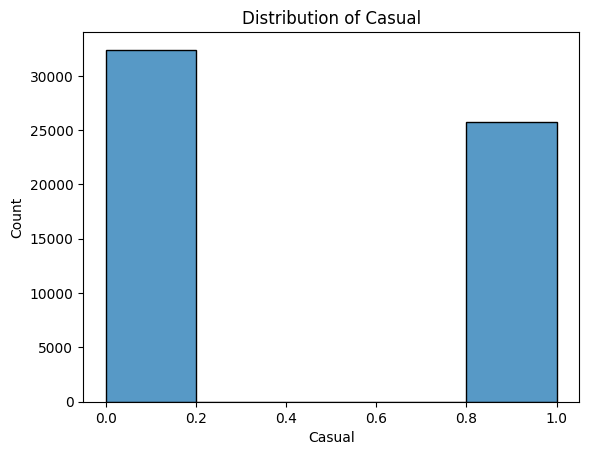

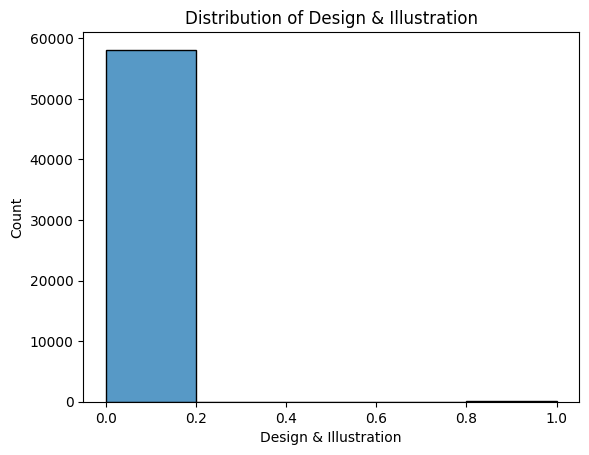

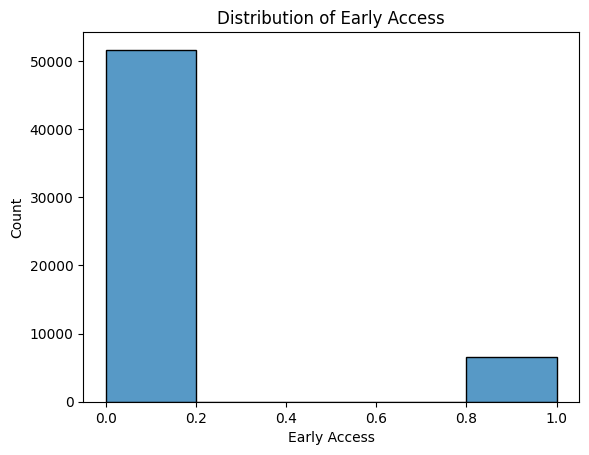

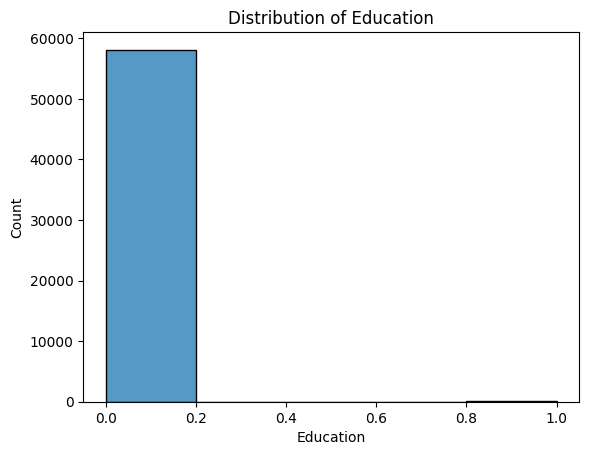

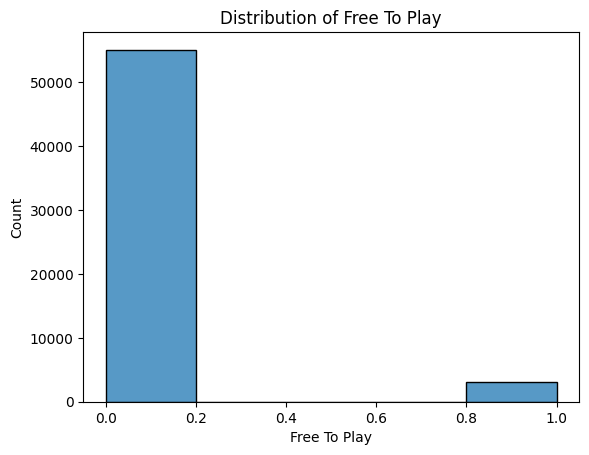

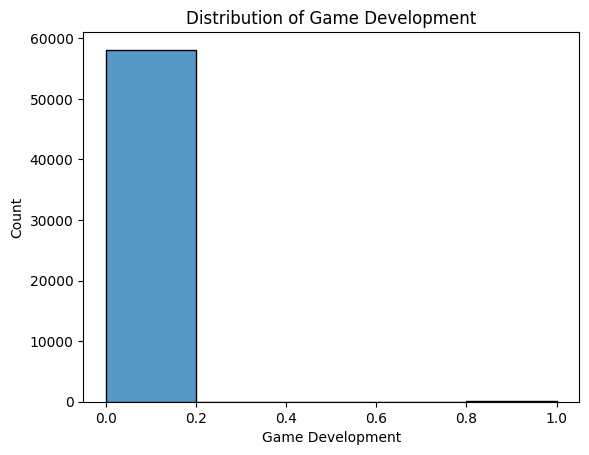

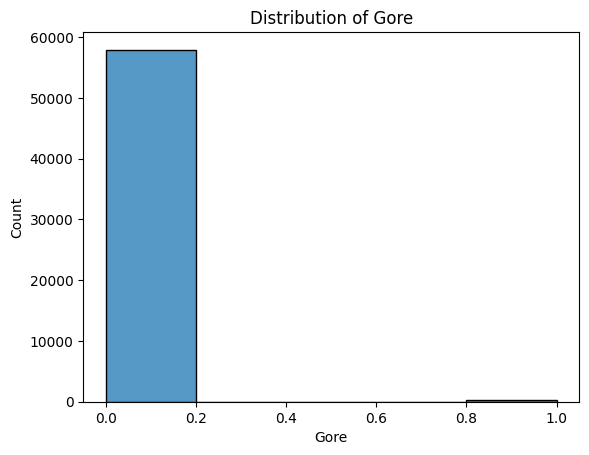

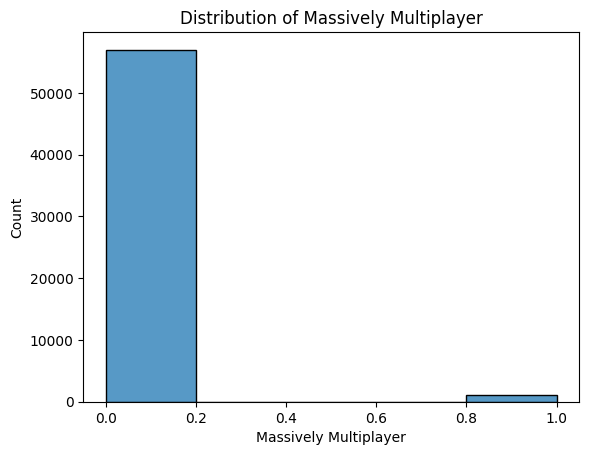

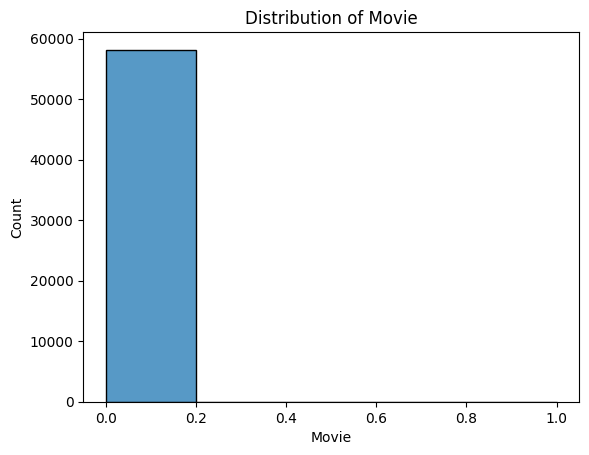

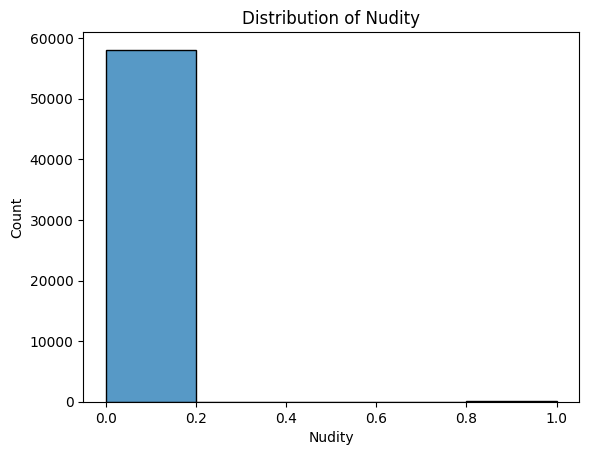

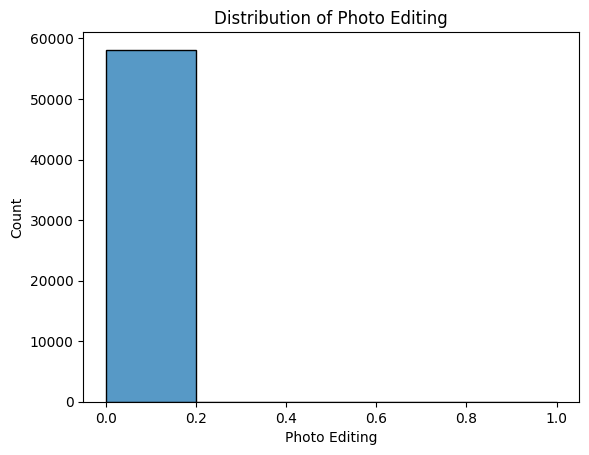

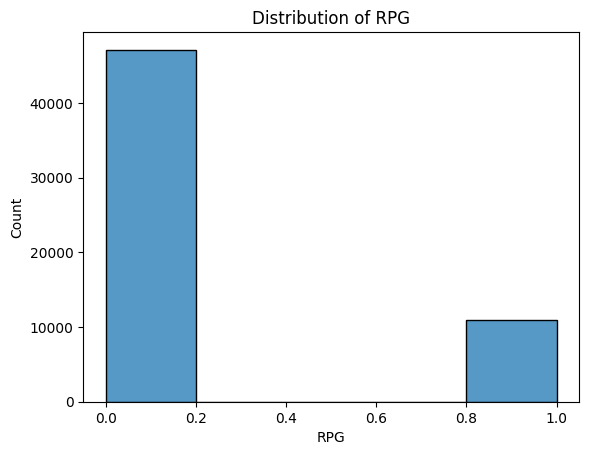

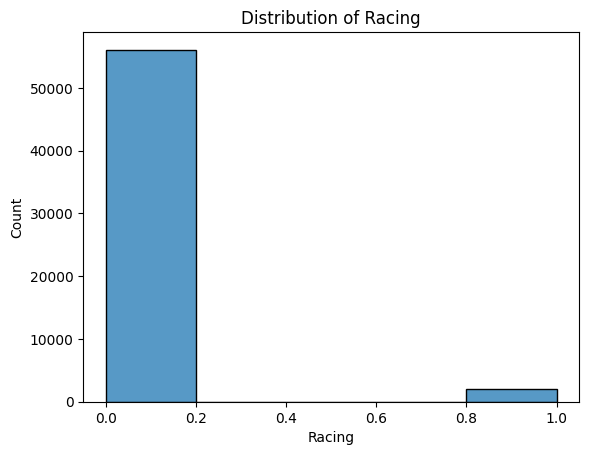

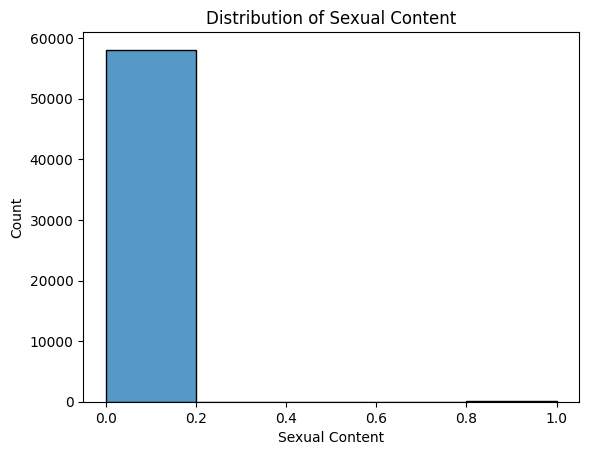

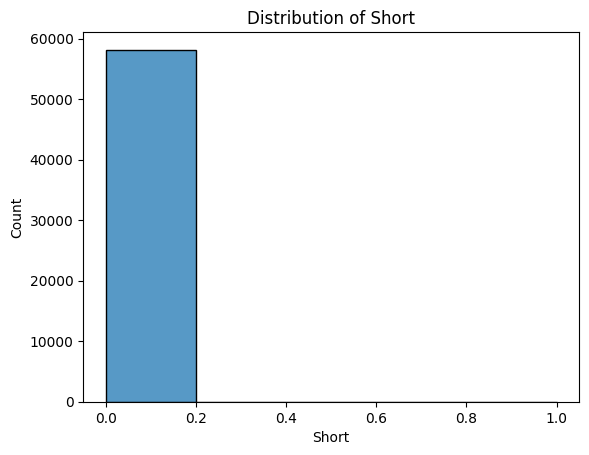

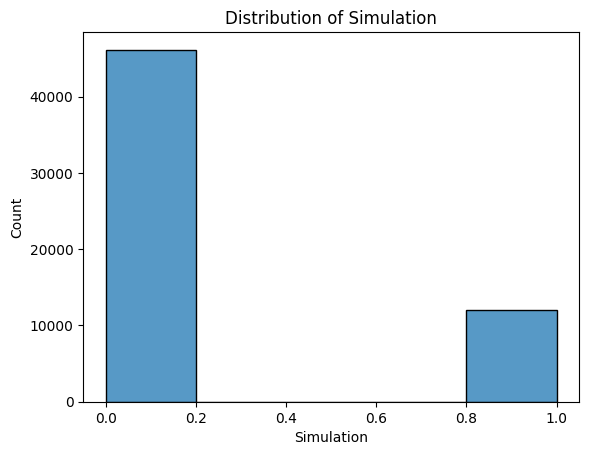

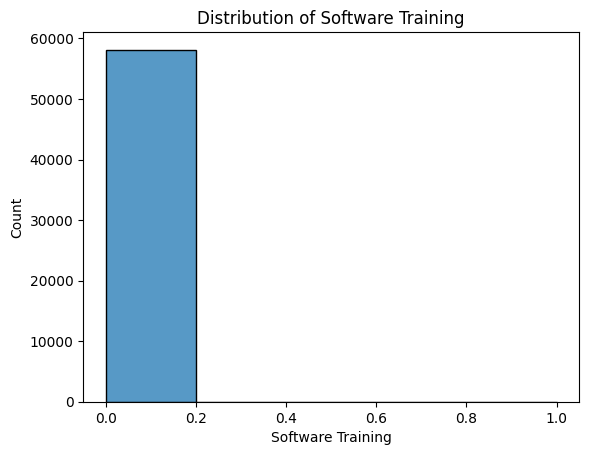

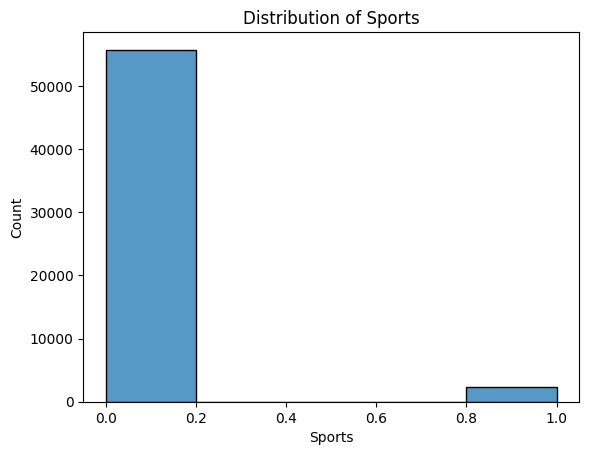

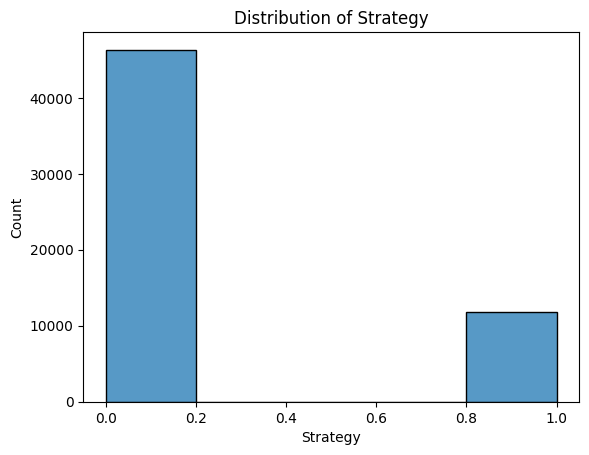

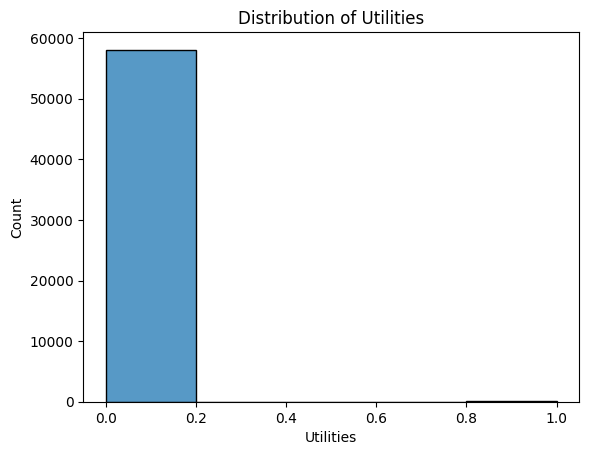

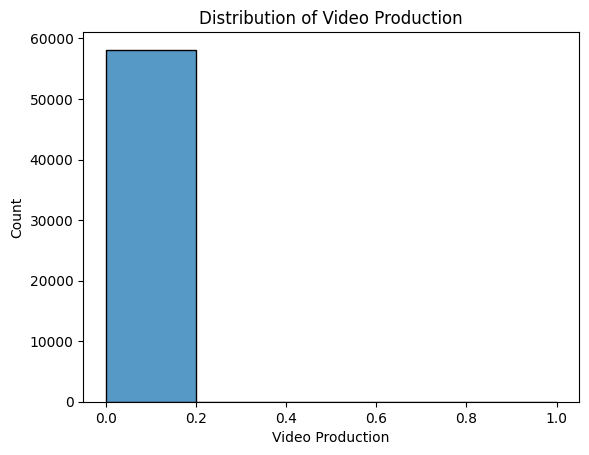

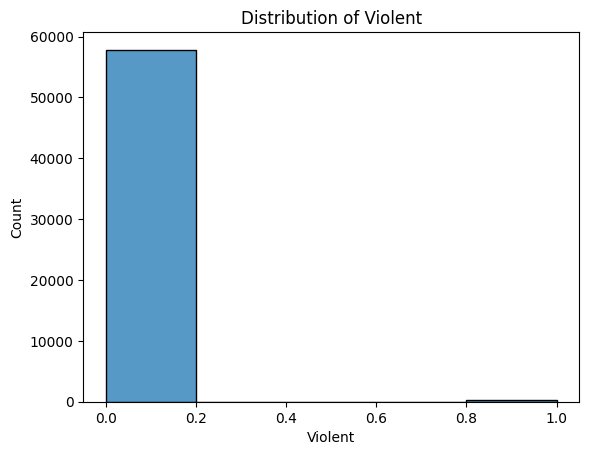

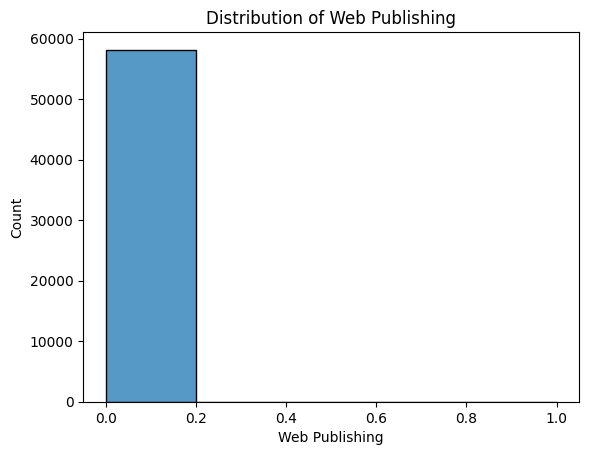

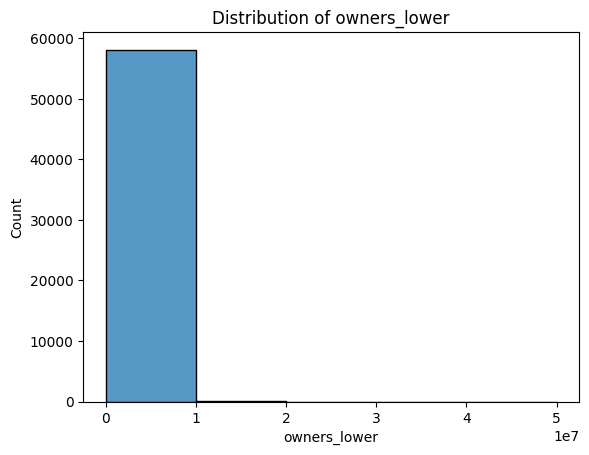

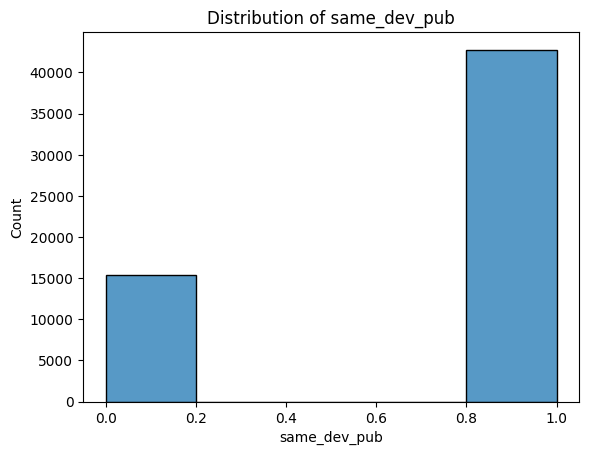

In [26]:
#looking at distribution of features
for column in df_final.columns:
    sns.histplot(df_final[column], kde=False, bins=5)
    plt.title(f"Distribution of {column}")
    plt.show()
#most features are heavily skewed, either but this is the first peek at which indie games are the most popular (action, adventure, casual)

In [27]:
#Looking at questions: Which genres are popular? Which genres are oversaturated?
#Popular = many ccu (concurrent users) / many owners (owners_lower: this has less granulated information) / high positive reviews + low negative reviews
#Oversaturated = high number of games in genre + low average number of players across genre
#Will provide numbers to these definitions after more EDA into these features
genre_list_sorted = df_final[genre_list].sum().sort_values(ascending=False).index.tolist()
df_final[genre_list].sum().sort_values(ascending=False)


Action                   26645
Casual                   25758
Adventure                25201
Simulation               12007
Strategy                 11823
RPG                      11006
Early Access              6520
Free To Play              3068
Sports                    2385
Racing                    2093
Massively Multiplayer     1167
Violent                    321
Gore                       209
Nudity                      76
Sexual Content              71
Utilities                   68
Education                   41
Design & Illustration       41
Animation & Modeling        38
Game Development            37
Audio Production            28
Video Production            25
Software Training           20
Photo Editing               18
Web Publishing              11
Accounting                   6
Short                        1
Movie                        1
dtype: int64

In [28]:
df_final.groupby(by = 'owners_lower')[genre_list_sorted].sum()

,Action,Casual,Adventure,Simulation,Strategy,RPG,Early Access,Free To Play,Sports,Racing,...,Animation & Modeling,Game Development,Audio Production,Video Production,Software Training,Photo Editing,Web Publishing,Accounting,Short,Movie
owners_lower,,,,,,,,,,,,,,,,,,,,,
0,18702,19398,17119,8496,7838,6804,4983,1273,1836,1584,...,27,30,23,19,14,12,6,3,1,0
20000,3654,3196,3765,1429,1679,1835,742,647,259,235,...,3,4,3,3,2,2,3,1,0,0
50000,1698,1390,1758,753,882,995,355,396,121,119,...,2,1,1,2,2,1,1,2,0,0
100000,1063,840,1125,522,601,571,201,317,82,78,...,0,0,0,0,0,0,0,0,0,0
200000,883,610,864,462,501,470,135,242,57,49,...,2,1,1,0,1,1,0,0,0,0
500000,322,190,324,187,182,199,62,105,17,15,...,1,0,0,0,1,0,1,0,0,1
1000000,181,79,138,93,82,78,25,49,7,7,...,1,0,0,1,0,0,0,0,0,0
2000000,92,37,72,44,43,31,10,21,3,2,...,1,1,0,0,0,1,0,0,0,0
5000000,27,13,17,8,8,8,1,14,1,3,...,0,0,0,0,0,0,0,0,0,0


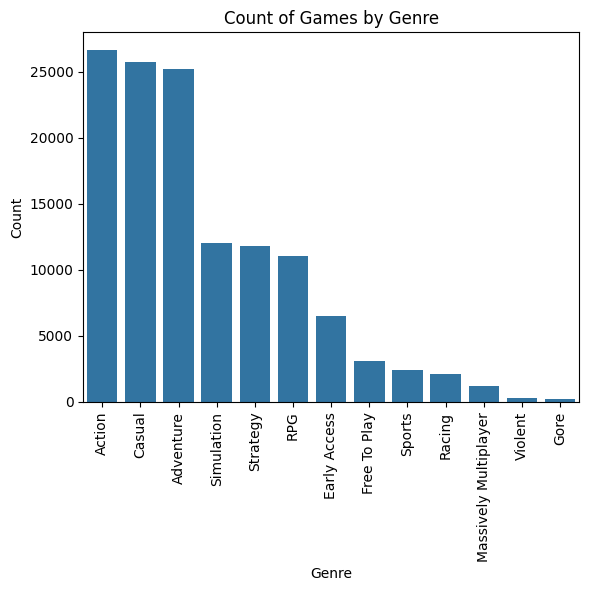

In [29]:
#Creating a bar plot with only top 13 genres to visualize the count of games by genre. Only the first 13 because these are most popular genres, and the rest are far less popular or non game types.
count_by_genre = df_final[genre_list_sorted].sum().iloc[0:13]
sns.barplot(x=count_by_genre.index, y=count_by_genre.values)
plt.xticks(rotation=90)
plt.title("Count of Games by Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()
#Most popular genres are Action, Adventure, and Casual

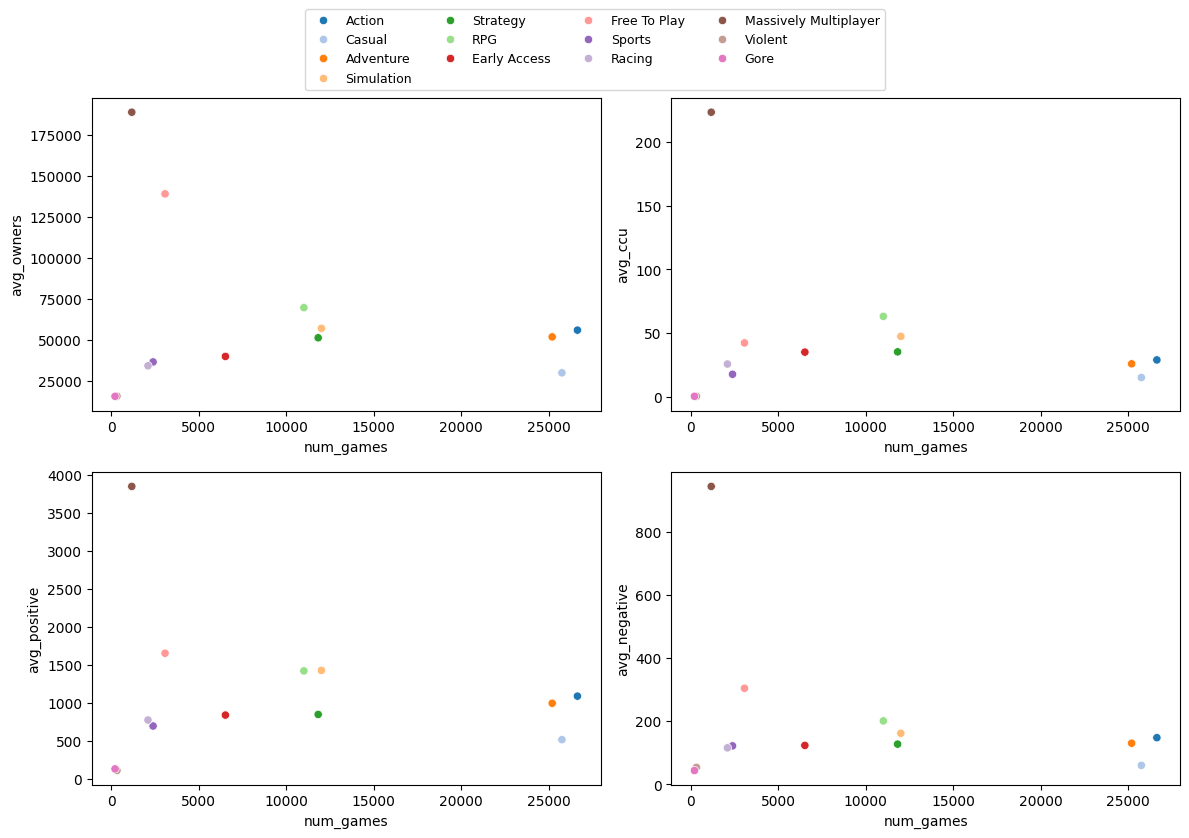

In [30]:
genre_stats = []

for genre in genre_list_sorted[0:13]:
    genre_df = df_final[df_final[genre]==1].copy()
    num_games = genre_df.shape[0]
    avg_owners = genre_df['owners_lower'].mean()
    avg_ccu = genre_df['ccu'].mean()
    avg_positive = genre_df['positive'].mean()
    avg_negative = genre_df['negative'].mean()
    genre_stats.append({
        'genre': genre,
        'num_games': num_games,
        'avg_owners': avg_owners,
        'avg_ccu': avg_ccu,
        'avg_positive': avg_positive,
        'avg_negative': avg_negative
    })
genre_stats_df = pd.DataFrame(genre_stats)
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(12, 8))
sns.scatterplot(x='num_games', y='avg_owners', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[0,0]).get_legend().remove()
sns.scatterplot(x='num_games', y='avg_ccu', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[0,1]).get_legend().remove()
sns.scatterplot(x='num_games', y='avg_positive', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[1,0]).get_legend().remove()
sns.scatterplot(x='num_games', y='avg_negative', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[1,1]).get_legend().remove()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), prop={'size': 9})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Interpreting the RAW scatter plots:
#oversaturated genres are those in bottom right quadrant, where there are many games in the genre but low average owners (casual, adventure, action)
#Undersaturated genres are those in the top left quadrant, where there are few games in the genre but high average owners (Massively Multiplayer, Free to Play)
#Added review informaiton to see if there are genres with average good or bad games (e.g. are saturate markets filled with bad games or good games?)
#The scatterplots look pretty identical to each other with positive ratings out-ranking negative ratings for all genre types (seen in the y-axis scaling)
#so we can conclude that that Massively Multiplayer and Free to Play genre are the best genres to make an indie game in, since they are undersaturated and have high average owners.
#Additionally: Sports, Racing, Violent, and Gore have few number of games with more mixed reviews. So making a great game in these genres could bring success if done well. However...
#There are not a lot of owners and concurrent users in these genres, so the game would have to attract players from other genres to be successful. 

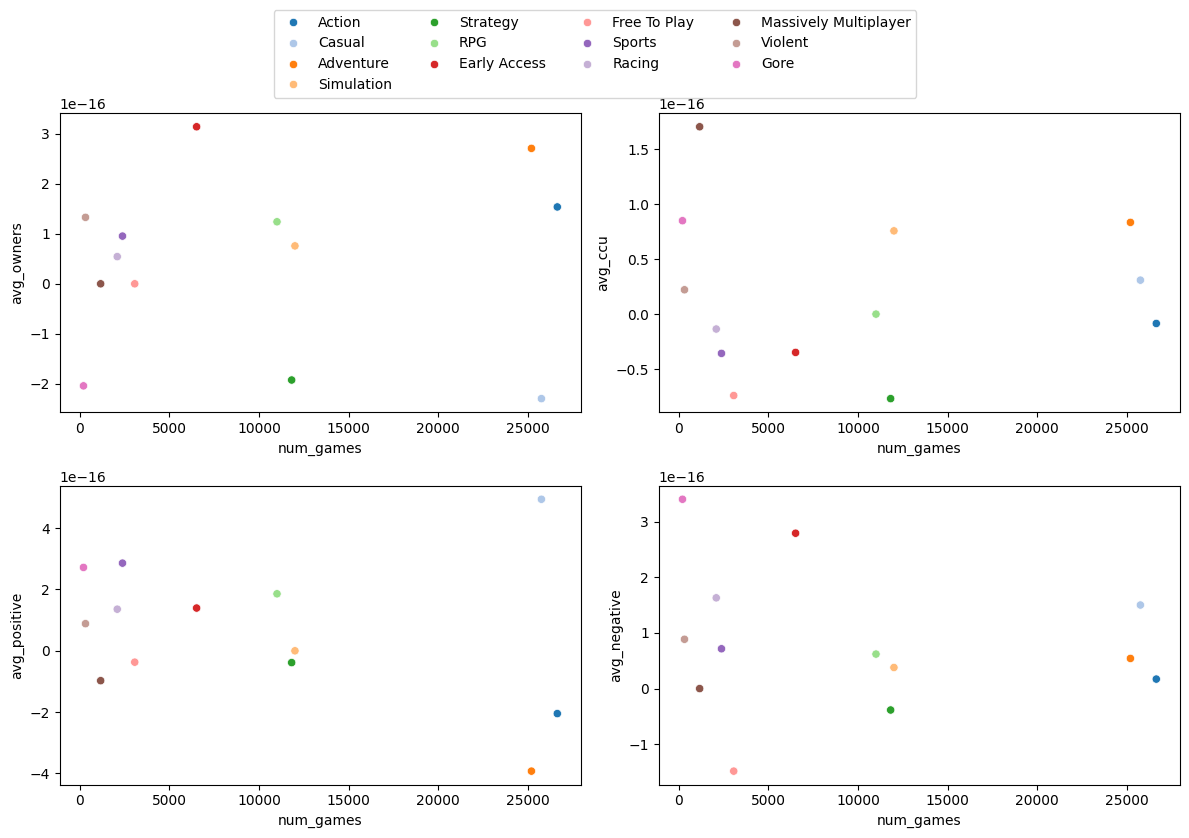

In [31]:
#Rerunning with PowerTransformer to normalize the data, to see what results change when normalizing the data before visualizing. 
genre_stats = []
#Creating a PowerTransformer to normalize the data, yeo-johnson used because all target variables have 0 values 
pt = PowerTransformer(method='yeo-johnson', standardize=True)


for genre in genre_list_sorted[0:13]:
    genre_df = df_final[df_final[genre]==1].copy()
    num_games = genre_df.shape[0]
    for col in ['owners_lower', 'ccu', 'positive', 'negative']:
        genre_df[col + '_pt'] = pt.fit_transform(genre_df[[col]])
    avg_owners = genre_df['owners_lower_pt'].mean()
    avg_ccu = genre_df['ccu_pt'].mean()
    avg_positive = genre_df['positive_pt'].mean()
    avg_negative = genre_df['negative_pt'].mean()
    genre_stats.append({
        'genre': genre,
        'num_games': num_games,
        'avg_owners': avg_owners,
        'avg_ccu': avg_ccu,
        'avg_positive': avg_positive,
        'avg_negative': avg_negative
    })
genre_stats_df = pd.DataFrame(genre_stats)
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(12, 8))
sns.scatterplot(x='num_games', y='avg_owners', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[0,0]).legend().remove()
sns.scatterplot(x='num_games', y='avg_ccu', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[0,1]).legend().remove()
sns.scatterplot(x='num_games', y='avg_positive', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[1,0]).legend().remove()
sns.scatterplot(x='num_games', y='avg_negative', hue='genre', data=genre_stats_df, palette='tab20', ax=ax[1,1]).legend().remove()
  # Remove the default legend
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), prop={'size': 10})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Interpreting the NORMALIZED scatter plots:
#NOT LOOKING AT RAW NUMBERS, BUT RELATIVE NUMBERS BASED ON RELATIONSHIP BETWEEN GAMES IN GENRES. THIS ALLOWS FOR RELATIVE COMPARISON BETWEEN GENRES
#oversaturated genres are those in bottom right quadrant, where there are many games in the genre but low average owners (casual, action)
#Undersaturated genres are those in the top left quadrant, where there are few games in the genre but high average owners (Early Access, Violent, Sports, Racing, RPG, Massively Multiplayer, Free to Play)
#Added review informaiton to see if there are genres with average good or bad games (e.g. are saturate markets filled with bad games or good games?), shows that gore has few games with mixed reviews
#so we can conclude that that are a few good genres to make an indie game in, since they are undersaturated and have high average owners relative to the other genres.
#Additionally (more suppoorting evidence here to the claim made above):
#Sports, Racing, Violent, and Gore have few number of games with more mixed reviews. So making a great game in these genres could bring success if done well. However...
#There are not a lot of owners and concurrent users in these genres, so the game would have to attract players from other genres to be successful. 

In [32]:
le = LabelEncoder()
df_final['owners_lower_encoded'] = le.fit_transform(df_final['owners_lower'])
print(df_final['owners_lower_encoded'].head())

3     11
10    11
17    10
19    10
21    10
Name: owners_lower_encoded, dtype: int64


In [33]:
X = df_final[genre_list]
y = df_final['owners_lower_encoded']  # Using owners_lower as the target variable for regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [34]:
#creating blank dataframe to store model accuracies
model_accuracy = pd.DataFrame(columns=['Model', 'Accuracy', 'Best_Params'])

In [35]:
#Looking at models with no transformations firts, since all variables are categorical and we want to see how they perform without any transformations

def fit_and_evaluate(models, X_train, y_train, X_test, y_test, param_grids=None):
    for name, model in models.items():
        param_grid = param_grids.get(name, None) if param_grids else None
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            best_model = model
            best_params = 'Default'
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Best Params: {best_params}")
        print(f"{name} Accuracy: {acc:.4f}")
        print(f"{name} Classification Report:\n{classification_report(y_test, y_pred, zero_division=np.nan)}")
        print(f"{name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
        model_accuracy.loc[len(model_accuracy)] = [name, acc, best_params]

        

In [36]:
base_models = {
    'Logistic Regression (base)': LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=7),
    'Random Forest (base)': RandomForestClassifier(random_state=7),
    'XGBoost (base)': XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softprob', random_state=7)
}
fit_and_evaluate(base_models, X_train, y_train, X_test, y_test)

Logistic Regression (base) Best Params: Default
Logistic Regression (base) Accuracy: 0.7044
Logistic Regression (base) Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      8195
           1       0.11      0.00      0.00      1619
           2        nan      0.00      0.00       747
           3        nan      0.00      0.00       460
           4       0.00      0.00      0.00       352
           5        nan      0.00      0.00       131
           6        nan      0.00      0.00        73
           7        nan      0.00      0.00        43
           8        nan      0.00      0.00         4
           9        nan      0.00      0.00         4
          10        nan      0.00      0.00         3
          11        nan      0.00      0.00         1

    accuracy                           0.70     11632
   macro avg       0.27      0.08      0.07     11632
weighted avg       0.59      0.70      0.58   

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:03:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (base) Best Params: Default
XGBoost (base) Accuracy: 0.7038
XGBoost (base) Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      8195
           1       0.43      0.00      0.01      1619
           2       0.25      0.01      0.01       747
           3       0.25      0.00      0.01       460
           4       0.10      0.00      0.01       352
           5       0.00      0.00      0.00       131
           6       0.00      0.00      0.00        73
           7        nan      0.00      0.00        43
           8        nan      0.00      0.00         4
           9        nan      0.00      0.00         4
          10        nan      0.00      0.00         3
          11        nan      0.00      0.00         1

    accuracy                           0.70     11632
   macro avg       0.25      0.08      0.07     11632
weighted avg       0.59      0.70      0.58     11632

XGBoost (base) Confusion Ma

In [37]:
GridSearchCV_models = {
    'Logistic Regression (GridSearchCV)': LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=7),
    'Random Forest (GridSearchCV)': RandomForestClassifier(random_state=7),
    'XGBoost (GridSearchCV)': XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softprob', random_state=7)
}

grid = {
    'Logistic Regression (GridSearchCV)': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
    },
    'Random Forest (GridSearchCV)': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost (GridSearchCV)': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    }
}

fit_and_evaluate(GridSearchCV_models, X_train, y_train, X_test, y_test, grid)

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression (GridSearchCV) Best Params: {'C': 1, 'solver': 'saga'}
Logistic Regression (GridSearchCV) Accuracy: 0.7044
Logistic Regression (GridSearchCV) Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      8195
           1       0.11      0.00      0.00      1619
           2        nan      0.00      0.00       747
           3        nan      0.00      0.00       460
           4       0.00      0.00      0.00       352
           5        nan      0.00      0.00       131
           6        nan      0.00      0.00        73
           7        nan      0.00      0.00        43
           8        nan      0.00      0.00         4
           9        nan      0.00      0.00         4
          10        nan      0.00      0.00         3
          11        nan      0.00      0.00         1

    accuracy                           0.70     11632
   macro avg       0.27      0.08      0.07     11632
wei

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest (GridSearchCV) Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest (GridSearchCV) Accuracy: 0.7043
Random Forest (GridSearchCV) Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      8195
           1       0.00      0.00      0.00      1619
           2       0.40      0.00      0.01       747
           3       0.00      0.00      0.00       460
           4        nan      0.00      0.00       352
           5        nan      0.00      0.00       131
           6        nan      0.00      0.00        73
           7        nan      0.00      0.00        43
           8        nan      0.00      0.00         4
           9        nan      0.00      0.00         4
          10        nan      0.00      0.00         3
          11        nan      0.00      0.00         1

    accuracy                           0.70     11632
   macro avg       0.28      0.08     

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:09:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (GridSearchCV) Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGBoost (GridSearchCV) Accuracy: 0.7045
XGBoost (GridSearchCV) Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      8195
           1        nan      0.00      0.00      1619
           2        nan      0.00      0.00       747
           3        nan      0.00      0.00       460
           4        nan      0.00      0.00       352
           5        nan      0.00      0.00       131
           6        nan      0.00      0.00        73
           7        nan      0.00      0.00        43
           8        nan      0.00      0.00         4
           9        nan      0.00      0.00         4
          10        nan      0.00      0.00         3
          11        nan      0.00      0.00         1

    accuracy                           0.70     11632
   macro avg       0.70      0.08      0.07     11632
weigh

In [38]:
print(model_accuracy.sort_values(by='Accuracy', ascending=False))
#There is no difference when using different preprocessing methods

                                Model  Accuracy  \
5              XGBoost (GridSearchCV)  0.704522   
0          Logistic Regression (base)  0.704436   
3  Logistic Regression (GridSearchCV)  0.704436   
4        Random Forest (GridSearchCV)  0.704264   
2                      XGBoost (base)  0.703834   
1                Random Forest (base)  0.701255   

                                         Best_Params  
5  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  
0                                            Default  
3                         {'C': 1, 'solver': 'saga'}  
4  {'max_depth': 10, 'min_samples_split': 10, 'n_...  
2                                            Default  
1                                            Default  


In [39]:
best_classifier = model_accuracy.sort_values(by='Accuracy', ascending=False).iloc[0]
print(f"Best Classifier: {best_classifier['Model']} with Accuracy: {best_classifier['Accuracy']:.4f} and Best Params: {best_classifier['Best_Params']}")

Best Classifier: XGBoost (GridSearchCV) with Accuracy: 0.7045 and Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


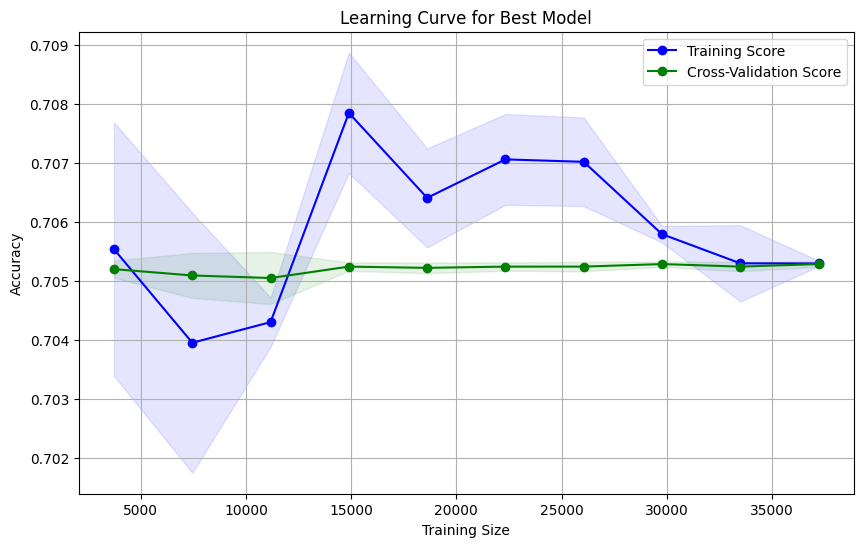

In [40]:
#recreating the best model with the best parameters for final use
#creating learning curve for the best model
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softprob', random_state=7, n_estimators=200, max_depth=3, learning_rate=0.01)
best_model.fit(X_train, y_train)

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=7
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [41]:
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross Validation Scores: [0.70524393 0.70531972 0.70521225 0.70531972 0.70531972]
Mean Accuracy: 0.7052830683733768
Standard Deviation of Accuracy: 4.599370310329738e-05


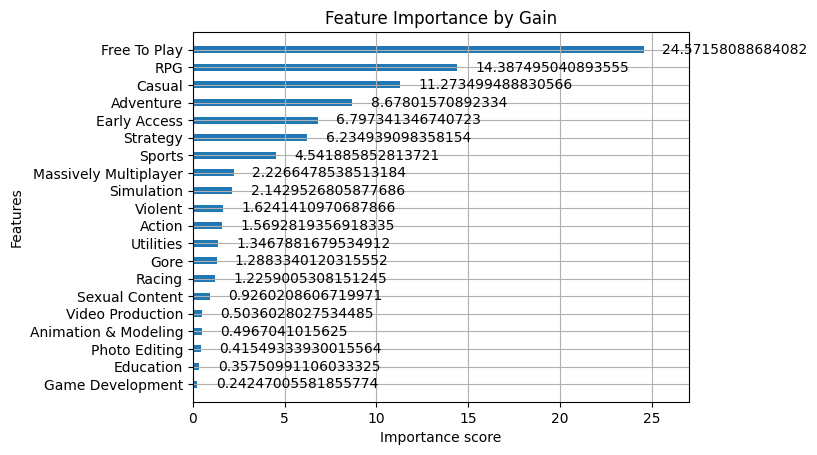

In [42]:
plot_importance(best_model, importance_type='gain', max_num_features=20, height=0.4, title='Feature Importance by Gain')
plt.show()
#free to play is the most important feature, showing that it is a strong indicator of success for indie games **MAKE YOUR INDIE GAME FREE TO PLAY**

In [43]:
rfe = RFE(estimator=best_model, n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected Features by RFE:", selected_features.tolist())

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:10:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:10:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:10:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are

Selected Features by RFE: ['Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Early Access', 'Education', 'Free To Play', 'Game Development', 'Gore', 'Massively Multiplayer', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent']


In [44]:
X = df_final[genre_list + ['positive', 'negative','userscore','average_forever','average_2weeks','median_forever','median_2weeks','ccu', 'same_dev_pub']]
y = df_final['owners_lower_encoded']  # Using owners_lower as the target variable for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# Re-running the best model with selected features

base_models_all_features = {
    'Logistic Regression (base_all_features)': LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=7),
    'Random Forest (base_all_features)': RandomForestClassifier(random_state=7),
    'XGBoost (base_all_features)': XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softprob', random_state=7)
}

GridSearchCV_models_all_features = {
    'Logistic Regression (GridSearchCV_all_features)': LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=7),
    'Random Forest (GridSearchCV_all_features)': RandomForestClassifier(random_state=7),
    'XGBoost (GridSearchCV_all_features)': XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='multi:softprob', random_state=7)
}

#Same grid as before, so no need to redefine it.

fit_and_evaluate(base_models_all_features, X_train, y_train, X_test, y_test)
fit_and_evaluate(GridSearchCV_models_all_features, X_train, y_train, X_test, y_test, grid)
fit_and_evaluate(base_models, X_train, y_train, X_test, y_test, grid)
fit_and_evaluate(GridSearchCV_models, X_train, y_train, X_test, y_test, grid)


C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (base_all_features) Best Params: Default
Logistic Regression (base_all_features) Accuracy: 0.7219
Logistic Regression (base_all_features) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      8195
           1       0.19      0.02      0.03      1619
           2       0.26      0.01      0.03       747
           3       0.29      0.11      0.16       460
           4       0.44      0.50      0.47       352
           5       0.29      0.18      0.22       131
           6       0.26      0.25      0.26        73
           7       0.45      0.35      0.39        43
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.33      0.01         3
          11       0.00      0.00      0.00         1

    accuracy                           0.72     11632
   macro avg       0.25      0.23      0.20     11632
weighte

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:10:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (base_all_features) Best Params: Default
XGBoost (base_all_features) Accuracy: 0.7570
XGBoost (base_all_features) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8195
           1       0.41      0.22      0.28      1619
           2       0.33      0.19      0.24       747
           3       0.36      0.26      0.30       460
           4       0.50      0.53      0.51       352
           5       0.50      0.36      0.42       131
           6       0.45      0.37      0.41        73
           7       0.57      0.37      0.45        43
           8       0.14      0.25      0.18         4
           9       0.00      0.00      0.00         4
          10       0.33      0.67      0.44         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.40      0.35      0.34     11632
weighted avg       0.71      0.76      0.72

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (GridSearchCV_all_features) Best Params: Default
Logistic Regression (GridSearchCV_all_features) Accuracy: 0.7219
Logistic Regression (GridSearchCV_all_features) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      8195
           1       0.19      0.02      0.03      1619
           2       0.26      0.01      0.03       747
           3       0.29      0.11      0.16       460
           4       0.44      0.50      0.47       352
           5       0.29      0.18      0.22       131
           6       0.26      0.25      0.26        73
           7       0.45      0.35      0.39        43
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.33      0.01         3
          11       0.00      0.00      0.00         1

    accuracy                           0.72     11632
   macro avg       0.25      0.23    

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:10:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (GridSearchCV_all_features) Best Params: Default
XGBoost (GridSearchCV_all_features) Accuracy: 0.7570
XGBoost (GridSearchCV_all_features) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8195
           1       0.41      0.22      0.28      1619
           2       0.33      0.19      0.24       747
           3       0.36      0.26      0.30       460
           4       0.50      0.53      0.51       352
           5       0.50      0.36      0.42       131
           6       0.45      0.37      0.41        73
           7       0.57      0.37      0.45        43
           8       0.14      0.25      0.18         4
           9       0.00      0.00      0.00         4
          10       0.33      0.67      0.44         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.40      0.35      0.34     11632
weighted avg       

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (base) Best Params: Default
Logistic Regression (base) Accuracy: 0.7219
Logistic Regression (base) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      8195
           1       0.19      0.02      0.03      1619
           2       0.26      0.01      0.03       747
           3       0.29      0.11      0.16       460
           4       0.44      0.50      0.47       352
           5       0.29      0.18      0.22       131
           6       0.26      0.25      0.26        73
           7       0.45      0.35      0.39        43
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.33      0.01         3
          11       0.00      0.00      0.00         1

    accuracy                           0.72     11632
   macro avg       0.25      0.23      0.20     11632
weighted avg       0.62      0.72      0.64   

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:11:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (base) Best Params: Default
XGBoost (base) Accuracy: 0.7570
XGBoost (base) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8195
           1       0.41      0.22      0.28      1619
           2       0.33      0.19      0.24       747
           3       0.36      0.26      0.30       460
           4       0.50      0.53      0.51       352
           5       0.50      0.36      0.42       131
           6       0.45      0.37      0.41        73
           7       0.57      0.37      0.45        43
           8       0.14      0.25      0.18         4
           9       0.00      0.00      0.00         4
          10       0.33      0.67      0.44         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.40      0.35      0.34     11632
weighted avg       0.71      0.76      0.72     11632

XGBoost (base) Confusion Ma

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

Logistic Regression (GridSearchCV) Best Params: {'C': 1, 'solver': 'lbfgs'}
Logistic Regression (GridSearchCV) Accuracy: 0.7219
Logistic Regression (GridSearchCV) Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      8195
           1       0.19      0.02      0.03      1619
           2       0.26      0.01      0.03       747
           3       0.29      0.11      0.16       460
           4       0.44      0.50      0.47       352
           5       0.29      0.18      0.22       131
           6       0.26      0.25      0.26        73
           7       0.45      0.35      0.39        43
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.33      0.01         3
          11       0.00      0.00      0.00         1

    accuracy                           0.72     11632
   macro avg       0.25      0.23      0.20     11632
we

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:22:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (GridSearchCV) Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost (GridSearchCV) Accuracy: 0.7556
XGBoost (GridSearchCV) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8195
           1       0.40      0.22      0.28      1619
           2       0.32      0.16      0.21       747
           3       0.34      0.22      0.27       460
           4       0.48      0.54      0.51       352
           5       0.46      0.34      0.39       131
           6       0.43      0.36      0.39        73
           7       0.65      0.35      0.45        43
           8       0.17      0.25      0.20         4
           9       0.00      0.00      0.00         4
          10       0.17      0.33      0.22         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.39      0.31      0.32     11632
weight

In [45]:
print(model_accuracy.sort_values(by='Accuracy', ascending=False))

                                              Model  Accuracy  \
16                     Random Forest (GridSearchCV)  0.757565   
14                                   XGBoost (base)  0.756964   
8                       XGBoost (base_all_features)  0.756964   
11              XGBoost (GridSearchCV_all_features)  0.756964   
17                           XGBoost (GridSearchCV)  0.755588   
10        Random Forest (GridSearchCV_all_features)  0.736159   
13                             Random Forest (base)  0.736159   
7                 Random Forest (base_all_features)  0.736159   
15               Logistic Regression (GridSearchCV)  0.721888   
12                       Logistic Regression (base)  0.721888   
9   Logistic Regression (GridSearchCV_all_features)  0.721888   
6           Logistic Regression (base_all_features)  0.721888   
5                            XGBoost (GridSearchCV)  0.704522   
3                Logistic Regression (GridSearchCV)  0.704436   
0                        

In [46]:
#grabbing the best classifier from all models and its parameters
best_classifier_all = model_accuracy.sort_values(by='Accuracy', ascending=False)
print(best_classifier_all['Best_Params'].iloc[0])

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [47]:
#Creating a pipeline with PowerTransformer and RandomForestClassifier to see if tranformations improve the model
pipe = Pipeline([
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('classifier', RandomForestClassifier(random_state=7, n_estimators=200, max_depth=20, min_samples_split=5))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Pipeline Accuracy: {acc:.4f}")
print(f"Pipeline Classification Report:\n{classification_report(y_test, y_pred, zero_division=np.nan)}")
print(f"Pipeline Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
model_accuracy.loc[len(model_accuracy)] = ['Pipeline with PowerTransformer and RandomForestClassifier', acc, 'n_estimators=200, max_depth=20, min_samples_split=5']

Pipeline Accuracy: 0.7585
Pipeline Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      8195
           1       0.41      0.21      0.28      1619
           2       0.36      0.20      0.25       747
           3       0.37      0.23      0.29       460
           4       0.49      0.55      0.52       352
           5       0.49      0.30      0.37       131
           6       0.54      0.38      0.45        73
           7       0.69      0.47      0.56        43
           8       0.00      0.00      0.00         4
           9       1.00      0.25      0.40         4
          10       1.00      0.33      0.50         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.56      0.32      0.38     11632
weighted avg       0.71      0.76      0.72     11632

Pipeline Confusion Matrix:
[[7940  211   30   10    4    0    0    0    0  

In [48]:
print(model_accuracy.sort_values(by='Accuracy', ascending=False))

                                                Model  Accuracy  \
18  Pipeline with PowerTransformer and RandomFores...  0.758511   
16                       Random Forest (GridSearchCV)  0.757565   
11                XGBoost (GridSearchCV_all_features)  0.756964   
14                                     XGBoost (base)  0.756964   
8                         XGBoost (base_all_features)  0.756964   
17                             XGBoost (GridSearchCV)  0.755588   
13                               Random Forest (base)  0.736159   
7                   Random Forest (base_all_features)  0.736159   
10          Random Forest (GridSearchCV_all_features)  0.736159   
15                 Logistic Regression (GridSearchCV)  0.721888   
12                         Logistic Regression (base)  0.721888   
9     Logistic Regression (GridSearchCV_all_features)  0.721888   
6             Logistic Regression (base_all_features)  0.721888   
5                              XGBoost (GridSearchCV)  0.70452

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


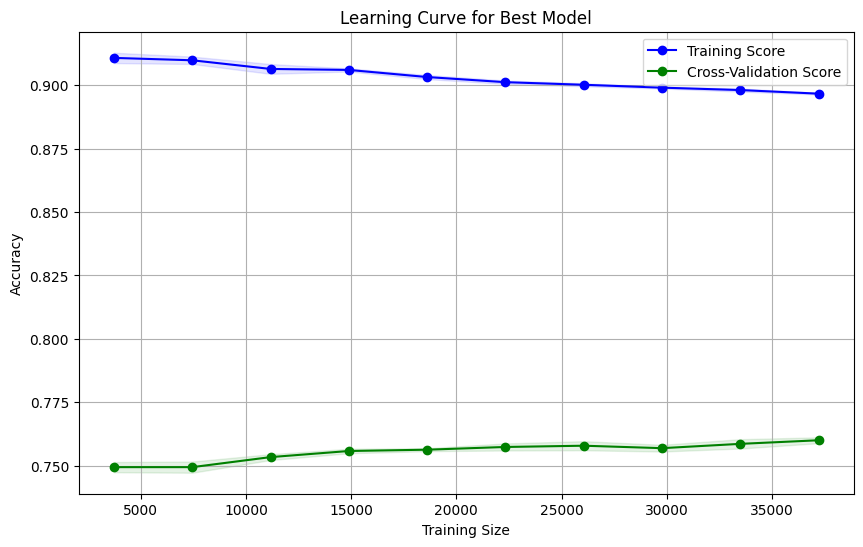

In [49]:
#recreating the best model with the best parameters for final use
#creating learning curve for the best model
train_sizes, train_scores, test_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=7
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#Shows classic issues of overfitting. Seen in the learning curve where the training score is much higher than the cross-validation score.

C:\Users\Liam\AppData\Local\Temp\ipykernel_27368\1820446959.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')


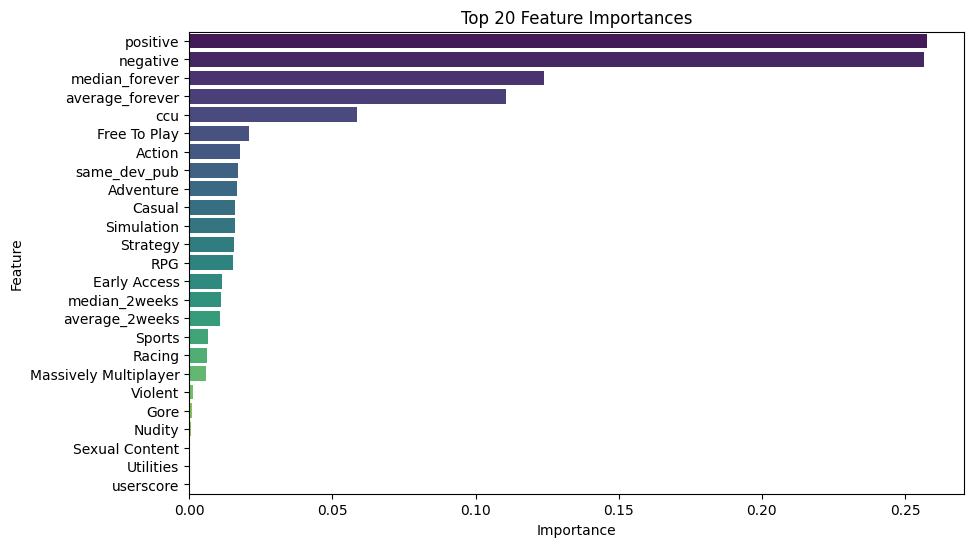

In [50]:
importance = pipe.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [51]:
#For trimmed models, so I can copy and paste the top genres
print(genre_list_sorted)

['Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Early Access', 'Free To Play', 'Sports', 'Racing', 'Massively Multiplayer', 'Violent', 'Gore', 'Nudity', 'Sexual Content', 'Utilities', 'Education', 'Design & Illustration', 'Animation & Modeling', 'Game Development', 'Audio Production', 'Video Production', 'Software Training', 'Photo Editing', 'Web Publishing', 'Accounting', 'Short', 'Movie']


In [52]:
#Trimming the features to only use the most important features based on the feature importance from the pipeline
#Especially some genres to remove noise from the model, since some genres are not as relevant to indie games
#This will help reduce noise and improve model performance
X = df_final[['Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Early Access', 'Free To Play', 'Sports', 'Racing', 'Massively Multiplayer',
              'Violent', 'Gore','positive', 'negative','average_forever','median_forever','ccu', 'same_dev_pub']]
y = df_final['owners_lower_encoded']  # Using owners_lower as the target variable for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

pipe_trimmed = Pipeline([
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('classifier', RandomForestClassifier(random_state=7, n_estimators=200, max_depth=20, min_samples_split=5))
])

pipe_trimmed.fit(X_train, y_train)
y_pred = pipe_trimmed.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Pipeline Accuracy: {acc:.4f}")
print(f"Pipeline Classification Report:\n{classification_report(y_test, y_pred, zero_division=np.nan)}")
print(f"Pipeline Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
model_accuracy.loc[len(model_accuracy)] = ['Pipeline with PowerTransformer and RandomForestClassifier', acc, 'n_estimators=200, max_depth=20, min_samples_split=5']

Pipeline Accuracy: 0.7602
Pipeline Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      8195
           1       0.41      0.22      0.29      1619
           2       0.33      0.18      0.23       747
           3       0.39      0.25      0.31       460
           4       0.50      0.57      0.53       352
           5       0.54      0.37      0.44       131
           6       0.58      0.40      0.47        73
           7       0.72      0.53      0.61        43
           8       0.00      0.00      0.00         4
           9        nan      0.00      0.00         4
          10       1.00      0.33      0.50         3
          11        nan      0.00      0.00         1

    accuracy                           0.76     11632
   macro avg       0.53      0.32      0.36     11632
weighted avg       0.71      0.76      0.73     11632

Pipeline Confusion Matrix:
[[7935  212   32   11    5    0    0    0    0  

C:\Users\Liam\AppData\Local\Temp\ipykernel_27368\837909399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')


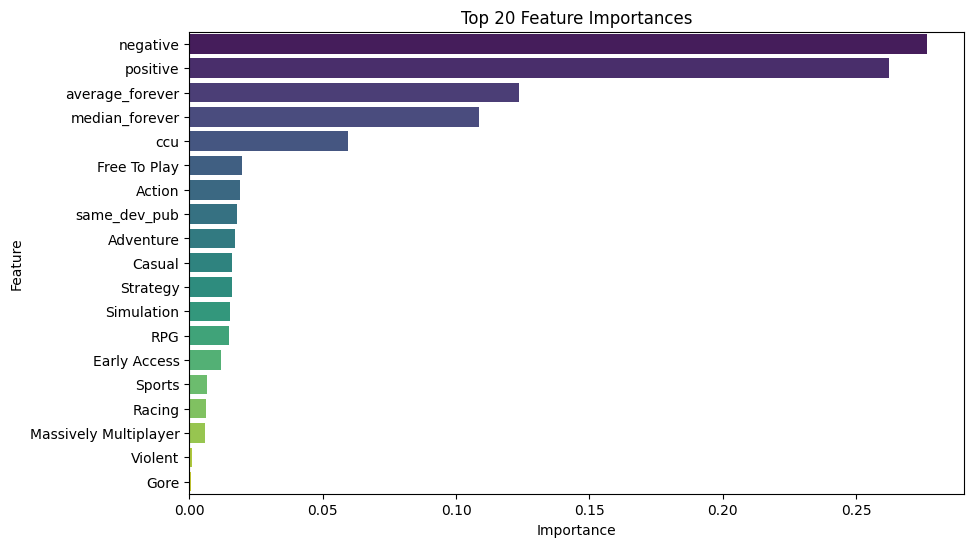

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


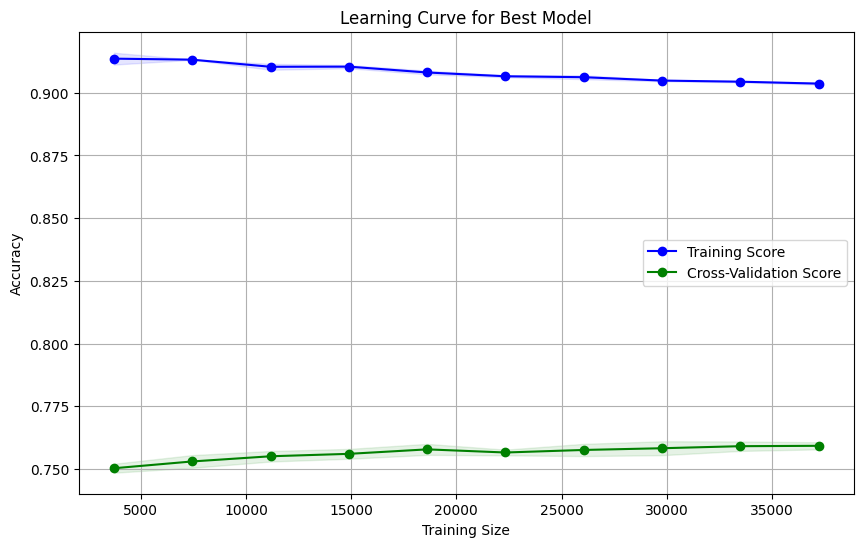

In [53]:
importance = pipe_trimmed.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    pipe_trimmed, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=7
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [54]:
print(y.groupby(y).count())
print(df_final['owners_lower'].value_counts())

#NOTES FOR NEXT TIME. NEED TO BIN THE OWNERS LOWER COLUMN TO MAKE IT MORE MEANINGFUL, SPECIFICALLY BIN 5-11 (AKA 1,00,000+) TRY PROGRESSIVELY LARGER BINS TO SEE MINIMAL VIABLE OPTION
#WANT TO KEEP AS MUCH INFORMATION AS POSSIBLE, SINCE IT IS NOT COMMON FOR INDIE GAMES TO HAVE MILLIONS OF OWNERS

owners_lower_encoded
0     41008
1      8017
2      3730
3      2343
4      1867
5       651
6       318
7       150
8        43
9        18
10       11
11        2
Name: owners_lower_encoded, dtype: int64
owners_lower
0           41008
20000        8017
50000        3730
100000       2343
200000       1867
500000        651
1000000       318
2000000       150
5000000        43
10000000       18
20000000       11
50000000        2
Name: count, dtype: int64


In [58]:
df_final['owners_binned'] = pd.cut(df_final['owners_lower'], bins=[-1, 100000, 500000, 1000000, 5000000, 10000000, np.inf], labels=[1, 2, 3, 4, 5, 6])
print(df_final['owners_binned'].value_counts())
print(df_final['owners_binned'].isna().sum())

owners_binned
1    55098
2     2518
3      318
4      193
5       18
6       13
Name: count, dtype: int64
0


In [ ]:
#Testing binned owners with the trimmed features
#Manual hyperparameter tuning was used. 
#Changed the max_depth to 10 and min_samples_split to 10 to reduce overfitting, since the model was overfitting on the training data.
#max_depth was changed because we didn't need that many levels of decision trees to classify. This was leading to overfitting.
#min_sample_split was changed to 10 to ensure that there were enough samples in each leaf node to make a decision, which helps reduce overfitting.
X = df_final[['Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Early Access', 'Free To Play', 'Sports', 'Racing', 'Massively Multiplayer',
              'Violent', 'Gore','positive', 'negative','average_forever','median_forever','ccu', 'same_dev_pub']]
y = df_final['owners_binned'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

pipe_binned = Pipeline([
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('classifier', RandomForestClassifier(random_state=7, n_estimators=200, max_depth=10, min_samples_split=10))
])

pipe_binned.fit(X_train, y_train)
y_pred = pipe_binned.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Pipeline Accuracy: {acc:.4f}")
print(f"Pipeline Classification Report:\n{classification_report(y_test, y_pred, zero_division=np.nan)}")
print(f"Pipeline Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
model_accuracy.loc[len(model_accuracy)] = ['Pipeline with PowerTransformer and RandomForestClassifier', acc, 'n_estimators=200, max_depth=20, min_samples_split=5']

#At 96.9% accuracy, this is the best model so far.

Pipeline Accuracy: 0.9693
Pipeline Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.99     11021
           2       0.71      0.58      0.63       483
           3       0.58      0.29      0.39        73
           4       0.66      0.57      0.61        47
           5        nan      0.00      0.00         4
           6       1.00      0.25      0.40         4

    accuracy                           0.97     11632
   macro avg       0.79      0.45      0.50     11632
weighted avg       0.97      0.97      0.97     11632

Pipeline Confusion Matrix:
[[10948    73     0     0     0     0]
 [  200   278     2     3     0     0]
 [   10    38    21     4     0     0]
 [    2     5    13    27     0     0]
 [    0     0     0     4     0     0]
 [    0     0     0     3     0     1]]



C:\Users\Liam\AppData\Local\Temp\ipykernel_27368\3614988873.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_binned_df.head(25), palette='viridis')


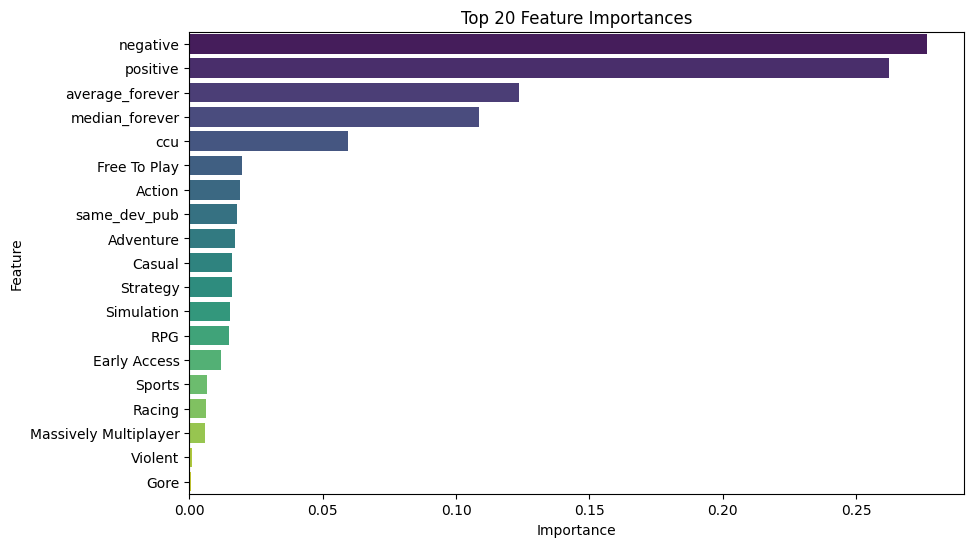

C:\Users\Liam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


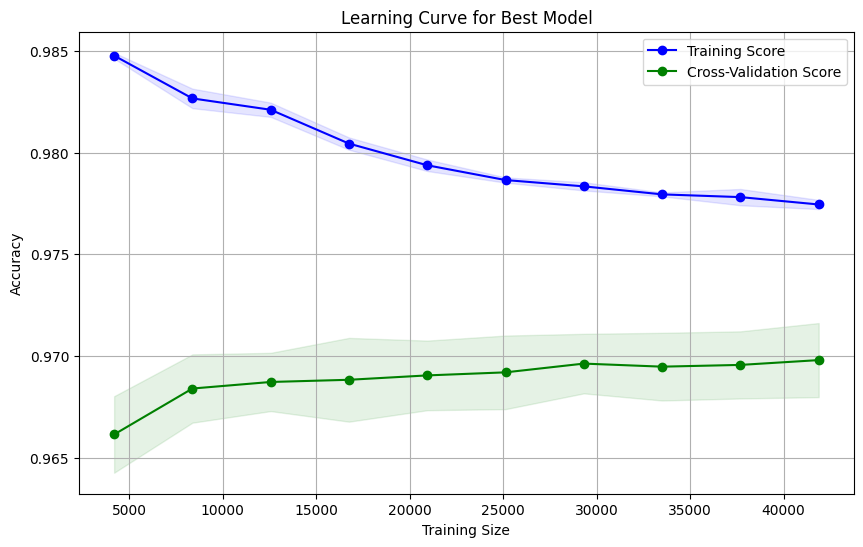

In [ ]:
importance_binned = pipe_binned.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
feature_importance_binned_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_binned}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_binned_df.head(25), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    pipe_binned, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=7
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#Much better learning curve, with less overfitting. The training score is closer to the cross-validation score, indicating that the model is generalizing better to unseen data.
#

In [ ]:

bin_map = {
    1: '0-100,000',
    2: '100,001-500,000',
    3: '500,001-1,000,000',
    4: '1,000,001-5,000,000',
    5: '5,000,001-10,000,000',
    6: '10,000,001+'
}
